# Analysis of classifiers robust to noisy labels

## Table of Content

**1.-** Load and Preprocessing Data<br>
**2.-** Utils Functions<br>
**3.-** Classifiers<br>
**3.1.-** T-Revision<br>
**3.1.1.-** First Training Stage<br>
**3.1.2.-** Generate transition matrix - CIFAR10<br>
**3.1.3.-** Validating the effectiveness of our estimator<br>
**3.1.4.-** Second Training Stage<br>
**3.2.-** Forward Method<br>
**4.-** Experiments<br>
**4.1.-** Classifier using Forward Method<br>
**4.1.1-** Training Function<br>
**4.1.2-** Run Experiment<br>
**4.1.3-** Results<br>
**4.2.-** Classifier using T-Revision Method<br>
**4.2.1-** ResNet Architecture<br>
**4.2.2-** Loss Function<br>
**4.2.3-** Training Function<br>
**4.2.4-** Run Experiment<br>
**4.2.5-** Results<br>
**4.3.-** Classifier using Importance Reweighting Method<br>
**4.3.1-** ResNet Architecture<br>
**4.3.2-** Loss Function<br>
**4.3.3-** Training Function<br>
**4.3.4-** Run Experiment<br>
**4.3.5-** Results<br>
**4.4.-** Baseline Results<br>
**4.4.1-** Generate Baseline Results<br>
**4.4.2-** Combining Results<br>

## Introduction

We explore contemporary robust classification algorithms for overcoming class-dependant  labelling  noise:   Forward,  Importance  Re-weighting  and  T-revision.The classifiers was trained and evaluated on class-conditional random label noisedata while the test data is clean.  We also estimated the transition matrix in orderto obtain more insight on the classifiers’ performance on noisy data.  The effec-tiveness and robustness of the classifiers were also analysed with experiments aswell as multiple evaluation metric comparisons.



In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

import random
import copy
import pandas as pd
from collections import OrderedDict

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import torch.optim as optim
import torch.autograd as autograd
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import datasets, models, transforms
import torchvision.transforms
from torch.utils.data import TensorDataset
import torchvision.models as models
from sklearn.model_selection import train_test_split

## 1.- Load and Preprocessing Data

###FashionMINIST0.5.npz
Number of the training and validation examples n = 18000

Number of the test examples m = 3000

The shape of each example image shape = (28 × 28)

The transition matrix:

$$ T=\begin{bmatrix}
0.5 & 0.2 & 0.3\\
0.3 & 0.5 & 0.2\\
0.2 & 0.3 & 0.5
\end{bmatrix}
$$

###FashionMINIST0.6.npz
Number of the training and validation examples n = 18000.

Number of the test examples m = 3000.

The shape of each example image shape = (28 × 28).

The transition matrix:

$$ T=\begin{bmatrix}
0.4 & 0.3 & 0.3\\
0.3 & 0.4 & 0.3\\
0.3 & 0.3 & 0.4
\end{bmatrix}
$$

###CIFAR.npz
Number of the training and validation examples n = 30000.

Number of the test examples m = 3000.

The shape of each example image shape = (32 × 32 × 3).

The transition matrix T is unknown.


**Note:** In this section you need to add the path to the file that contains the datasets. Additionally, if you use Google Colab you just need to mount your Drive Folder using the lines above.


In [ ]:
def load_data(file):
  """
  Function to load numpy datasets

  :param file: Dir
  :return X_train: Training images with shape (num_images, channels, width, height)
  :return y_train: Training labels with shape (num_labels)
  :return X_test: Testing images with shape (num_images, channels, width, height)
  :return y_test: Testing labels with shape (num_labels)
  """ 

  dataset = np.load(file)
  X_train = dataset['Xtr']/255
  y_train = dataset['Str']
  X_test = dataset['Xts']/255
  y_test = dataset['Yts']

  if X_train.ndim == 4:
    X_train = np.rollaxis(X_train, 3, 1)
    X_test = np.rollaxis(X_test, 3, 1)

  elif X_train.ndim == 3:
    X_train = X_train[..., np.newaxis]
    X_test = X_test[..., np.newaxis]
    X_train = np.rollaxis(X_train, 3, 1)
    X_test = np.rollaxis(X_test, 3, 1)

  return X_train, y_train, X_test, y_test

As we are running the Notebook using Google Colab, we need to mount our drive folder to read the data. If you run the code in your local machine, this line is not necessary.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Reading data - You need to add the path to the folder with the datasets in the next cell.
dataset = "cifar"

In [ ]:
available_datasets = {'cifar': '/content/drive/My Drive/comp5328-assignment-2/data/CIFAR.npz',
                      'fashionmnist0.5': '/content/drive/My Drive/comp5328-assignment-2/data/FashionMNIST0.5.npz',
                      'fashionmnist0.6': '/content/drive/My Drive/comp5328-assignment-2/data/FashionMNIST0.6.npz'}

T_matrices = {'cifar': None,
              'fashionmnist0.5': torch.Tensor([[0.5, 0.2, 0.3], [0.3, 0.5, 0.2], [0.2, 0.3, 0.5]]).cuda(),
              'fashionmnist0.6': torch.Tensor([[0.4, 0.3, 0.3], [0.3, 0.4, 0.3], [0.3, 0.3, 0.4]]).cuda()}

if dataset.lower() in available_datasets:
  dir = available_datasets[dataset.lower()]
  T_matrix = T_matrices[dataset.lower()]
  X_train, y_train, X_test, y_test = load_data(dir)
  print(f"Dataset {dataset} loaded.\n")

  print(f"Shape Xtr: {X_train.shape}")
  print(f"Shape Str: {y_train.shape}")
  print(f"Shape Xts: {X_test.shape}")
  print(f"Shape Yts: {y_test.shape}")

  print(f"\nTransition Matrix: \n{T_matrix}")
else:
  print("Dataset not valid. The dataset available are: cifar, fashionmnist0.5 and fashionmnist0.6")

Dataset cifar loaded.

Shape Xtr: (15000, 3, 32, 32)
Shape Str: (15000,)
Shape Xts: (3000, 3, 32, 32)
Shape Yts: (3000,)

Transition Matrix: 
None


## 2.- Utils Functions

In this section, you will find utility functions that will be used in the implementation of the classifiers & transition matrix.

### 2.1.- Display Images

This section contains functions to display images from the dataset

In [ ]:
def transform_img(img):
  """
  Function to transform the image shape to display it

  :param img: Image
  :return Reshaped image
  """
  return np.squeeze(np.transpose(img, (1, 2, 0)))

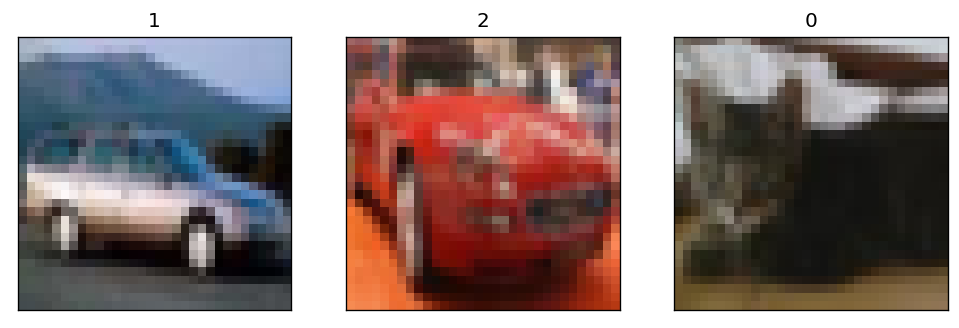

In [ ]:
# Example images
plt.figure(figsize=(10,10), dpi=120)
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
      
    img_reshaped = transform_img(X_train[i])
    label = y_train[i]

    # Set title
    plt.title(f'{label}', fontsize=12)

    # Get label for this image
    plt.imshow(img_reshaped, cmap=plt.cm.gray)
plt.show()

### 2.2.- Training and Evaluation

This section contains functions that help us train and evaluate our model, as well as to estimate the transition matrix.

In [ ]:
# When all random seeds are fixed, the python runtime environment becomes deterministic.
def seed_torch(seed=1029):
    """
    Function to set seed
    """
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # If multi-GPUs are used. 
    torch.cuda.manual_seed_all(seed) 
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [ ]:
# Set seed
seed_torch()

In [ ]:
class DatasetArray(Dataset):
  """This is a child class of the pytorch Dataset object."""
  def __init__(self, data, labels=None, transform=None):
      self.data_arr = np.asarray(data).astype(np.float32)
      self.label_arr = np.asarray(labels).astype(np.long)
      self.transform = transform
      
  def __len__(self):
      return len(self.data_arr)
  
  def __getitem__(self, index):
      data = self.data_arr[index]
      label = self.label_arr[index]
      
      if self.transform is not None:
        data = self.transform(data)
          
      return (data, label)


def get_loader(batch_size=128, num_workers = 1, val_split=0.2, X_train=None, y_train=None, X_test=None, y_test=None, transform=False):
  """
  Function to perform the train test split and return the DataLoader objects for each set.
  
  :param batch_size = Number of batch size
  :param num_workers = Number of workers for DataLoader
  :param val_split = Percentage to split the training set into training and validation set
  :param X_train = X_train data
  :param y_train = y_train data
  :param X_test = X_test data
  :param y_test = y_test data
  :return X_train DataLoader
  :return X_val DataLoader
  :return X_test DataLoader
  """

  # Split data
  if val_split != 0.0:
    print(f"Validation Split: {val_split}")
    X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                      y_train,
                                                      test_size=val_split, 
                                                      random_state=42)
    
    train_data = DatasetArray(data=X_train, labels=y_train)
    val_data = DatasetArray(data=X_val, labels=y_val)
    test_data = DatasetArray(data=X_test, labels=y_test)

    train_loader = DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
    )

    val_loader = DataLoader(
        val_data,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
    )

    test_loader = DataLoader(
        test_data,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=False,
    )
    return train_loader, val_loader, test_loader
  
  else:
    print(f"No Validation Split Inserted - Returning the entire dataset")
    train_data = DatasetArray(data=X_train, labels=y_train)

    train_loader = DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
    )
    return train_loader, None, None

In [ ]:
def prediction(model, test_loader, device, revision=False):
    """
    Function to generate predictions

    :param model: Model
    :param test_loader: Test DataLoader
    :param device: GPU or CPU
    :param revision: True or False - T-revision method
    :return y_true: True labels
    :return y_pred: Predicted labels
    :return acc: Accuracy
    :return outputs: Output from the softmax function
    :return predictions: Output from the argmax function applied to the softmax output
    """

    # Prepare the model to be evaluated
    model.eval()
    
    # Create empty tensors to store the results
    y_true = torch.tensor([], dtype=torch.long, device=device)
    all_outputs = torch.tensor([], device=device)
    
    # Deactivate autograd engine to reduce memory usage
    with torch.no_grad():
        #for data in test_loader:
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            if revision:
              outputs = model(inputs, revision=revision)
              outputs = outputs[0]
            else:
              outputs = model(inputs)
            y_true = torch.cat((y_true, labels), 0)
            all_outputs = torch.cat((all_outputs, outputs), 0)
    
    # Get the output from the softmax layer
    outputs = F.softmax(all_outputs, dim=1)

    # Convert the true labels to numpy
    y_true = y_true.cpu().numpy()

    # Get pred values from the model
    _, y_pred = torch.max(all_outputs, 1)
    y_pred = y_pred.cpu().numpy()
    
    # Calculate accuracy
    acc = sum(y_true == y_pred)/len(y_pred)
    return y_true, y_pred, acc, outputs

In [ ]:
def estimate_tmatrix(num_classes, outputs, y_pred, average=True):
  """
  Function to estimate the transition matrix based on the noisy class posterior

  :param num_classes: Number of classes
  :param outputs: Outputs from the softmax function
  :param y_pred: Prediction values
  :param average: Average the probabilities for each layer P(Y^{~}=i | x)
  :return T: Estimated transition matrix
  """

  T = np.empty((num_classes, num_classes))
  # Iterate over the number of classes
  for i in range(num_classes):
    # Average the probability per column
    if average:
      # Get the samples with this predicted class
      # Get the samples of these indexes P(Y^=i | X=Xi)
      Xi_outputs = outputs[(y_pred == i)]

      T[i, :] = np.mean(Xi_outputs, axis=0)
    
    else:
      # Get the argmax
      idx = np.argmax(outputs[:, i])
      # Iterave over each label to fill the matrix
      for j in np.arange(num_classes):
        T[i, j] = outputs[idx, j]
  return T

## 3.- Classifiers robust to label noise

In this section, we present the implementation of two classifiers which are robust to label noise. A detailed formulation of each one are provided in the report.

### 3.1- T-Revision

We first initialize the transition matrix by exploiting examples that are similar to anchor points, namely, those having high estimated noisy class
posterior probabilities. Then, we modify the initial matrix by adding a slack variable, which will be learned and validated together with the classifier by using noisy data only.

#### 3.1.1.- First Training Stage

In this stage we should learn $\widehat{T}$ using the noisy training data. We will train the neural network to learn the noisy class posterior and estimate the transition matrix using this neural network. In this case, we will use the ResNet as the paper does.

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, T=None):
  """
  Function to train the model
  
  :param model: Model
  :param T: Transition Matrix
  :param dataloaders: DataLoader
  :param criterion: Loss function
  :param optimizer: Optimizer
  :param num_epochs: Number of epochs
  :return model: Trained model
  """

  val_acc_history = []
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  print(f"Transition Matrix: \n{T}\n")

  for epoch in range(num_epochs):
      print('Epoch {}/{}'.format(epoch, num_epochs - 1))
      print('-' * 10)

      # Each epoch has a training and validation phase
      for phase in ['train', 'val']:
          if phase == 'train':
              model.train()  # Set model to training mode
          else:
              model.eval()   # Set model to evaluate mode

          running_loss = 0.0
          running_corrects = 0

          # Iterate over data.
          for inputs, labels in dataloaders[phase]:
              inputs = inputs.to(device)
              labels = labels.to(device)

              # zero the parameter gradients
              optimizer.zero_grad()

              # forward
              # track history if only in train
              with torch.set_grad_enabled(phase == 'train'):
                  outputs = model(inputs)
                  loss = criterion(outputs, labels)
                  
                  if torch.is_tensor(T):
                    prob = F.softmax(outputs, dim=1)
                    prob = prob.t()
                    out_forward = torch.matmul(T.t(), prob)
                    out_forward = out_forward.t()

                    _, preds = torch.max(out_forward, 1)
                  else:
                    _, preds = torch.max(outputs, 1)

                  # backward + optimize only if in training phase
                  if phase == 'train':
                      loss.backward()
                      optimizer.step()

              # statistics
              running_loss += loss.item() * inputs.size(0)
              running_corrects += torch.sum(preds == labels.data)

          epoch_loss = running_loss / len(dataloaders[phase].dataset)
          epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

          print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

          # deep copy the model
          if phase == 'val' and epoch_acc > best_acc:
              best_acc = epoch_acc
              best_model_wts = copy.deepcopy(model.state_dict())
          if phase == 'val':
              val_acc_history.append(epoch_acc)

      print()

  print('Best val Acc: {:4f}'.format(best_acc))

  # load best model weights
  model.load_state_dict(best_model_wts)
  return model, val_acc_history

def set_parameter_requires_grad(model, feature_extracting):
  """
  Function to define if feature extracting
  
  :param model: Model
  :param feature_extracting: Boolean to indicate if perform feature extraction
  """
  if feature_extracting:
      for param in model.parameters():
          param.requires_grad = False

In [ ]:
# Clean cache
with torch.no_grad():
    torch.cuda.empty_cache()
    
# Define parameters
num_classes = 3
batch_size = 128
num_epochs = 10
use_pretrained = False
feature_extract = False

# Initialize ResNet model
model_resnet = models.resnet18(pretrained=use_pretrained)

# Replace 1st conv layer with 1 channel if fashionMNIST
if X_train.shape[1] == 1:
  model_resnet.conv1 = torch.nn.Conv1d(1, 64, (7, 7), (2, 2), (3, 3), bias=True)
      
set_parameter_requires_grad(model_resnet, feature_extract)
num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_ftrs, num_classes)
input_size = 224

# Detect if GPU or CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Now we need to generate our Training, Validation and Testing DataLoaders

In [ ]:
train_loader, val_loader, test_loader = get_loader(X_train=X_train, 
                                                   y_train=y_train, 
                                                   X_test=X_test, 
                                                   y_test=y_test, 
                                                   batch_size=batch_size,
                                                   transform=True)

dataloaders_dict = {'train': train_loader, 'val': val_loader}

Validation Split: 0.2


Training the model to estimate the transition matrix

In [ ]:
# If GPU: send the model to GPU
model_resnet = model_resnet.to(device)

# Generate a list of parameters to learn based on feature_extraction or pretrained model
params_to_update = model_resnet.parameters()
if feature_extract:
  params_to_update = []
  for name,param in model_resnet.named_parameters():
    if param.requires_grad == True:
      params_to_update.append(param)

# Define optimizer
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

# Define Loss Function
criterion = nn.CrossEntropyLoss()

# Train and Evaluate model
model_resnet, hist = train_model(model_resnet, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Transition Matrix: 
None

Epoch 0/9
----------
train Loss: 1.1623 Acc: 0.3444
val Loss: 1.1376 Acc: 0.3370

Epoch 1/9
----------
train Loss: 1.1048 Acc: 0.3844
val Loss: 1.1601 Acc: 0.3417

Epoch 2/9
----------
train Loss: 1.0652 Acc: 0.4267
val Loss: 1.1241 Acc: 0.3657

Epoch 3/9
----------
train Loss: 1.0163 Acc: 0.4882
val Loss: 1.1306 Acc: 0.3590

Epoch 4/9
----------
train Loss: 0.9340 Acc: 0.5653
val Loss: 1.2366 Acc: 0.3457

Epoch 5/9
----------
train Loss: 0.8585 Acc: 0.6171
val Loss: 1.2499 Acc: 0.3567

Epoch 6/9
----------
train Loss: 0.7566 Acc: 0.6763
val Loss: 1.3596 Acc: 0.3527

Epoch 7/9
----------
train Loss: 0.6421 Acc: 0.7361
val Loss: 1.5339 Acc: 0.3417

Epoch 8/9
----------
train Loss: 0.5523 Acc: 0.7807
val Loss: 1.5994 Acc: 0.3620

Epoch 9/9
----------
train Loss: 0.4485 Acc: 0.8262
val Loss: 1.8324 Acc: 0.3400

Best val Acc: 0.365667


Now, we need to evaluate our entire training set using the previous model. We set the `val_split=0.0` to return the entire training set.

In [ ]:
train_loader, val_loader, test_loader = get_loader(X_train=X_train, 
                                                   y_train=y_train, 
                                                   X_test=X_test, 
                                                   y_test=y_test, 
                                                   val_split=0.0,
                                                   batch_size=batch_size)

y_true, y_pred, acc, outputs = prediction(model_resnet, train_loader, device)

print(f"\nAccuracy: {acc}")

No Validation Split Inserted - Returning the entire dataset

Accuracy: 0.4577333333333333


#### 3.1.2.- Generate transition matrix - CIFAR10

The function `estimate_tmatrix` contains the code to estimate the transition matrix.

In [ ]:
# Using average
estimated_T = estimate_tmatrix(num_classes=num_classes, 
                               outputs=outputs.cpu().numpy(), 
                               y_pred=y_pred)

print(f"Estimated Transition Matrix: \n{np.round(estimated_T, 4)}")

Estimated Transition Matrix: 
[[0.4395 0.3019 0.2586]
 [0.283  0.4672 0.2498]
 [0.2788 0.2901 0.4311]]


Now, we can update the value of the transition matrix for the CIFAR dataset in the `T_matrices` dictionary

In [ ]:
T_matrices['cifar'] = torch.from_numpy(estimated_T).float().cuda()

#### 3.1.3.- Validating the effectiveness of our estimator - FashionMNIST0.6

We will validate the effectiveness of our estimator using the dataset `FashionMNIST0.6`, where the transition matrix is already provided:

$$\begin{bmatrix}
0.4 & 0.3 & 0.3\\
0.3 & 0.4 & 0.3\\
0.3 & 0.3 & 0.4
\end{bmatrix}$$

The ResNet will be trained using the `FashionMNIST0.6 dataset` and we compare the estimated transition matrix with the provided one. Firstly, we load the dataset.

In [ ]:
# Reading data - You need to add the path to the folder with the datasets here.
dataset = "fashionmnist0.6"

available_datasets = {'cifar': '/content/drive/My Drive/comp5328-assignment-2/data/CIFAR.npz',
                      'fashionmnist0.5': '/content/drive/My Drive/comp5328-assignment-2/data/FashionMNIST0.5.npz',
                      'fashionmnist0.6': '/content/drive/My Drive/comp5328-assignment-2/data/FashionMNIST0.6.npz'}

if dataset.lower() in available_datasets:
  dir = available_datasets[dataset.lower()]
  T_matrix = T_matrices[dataset.lower()]
  X_train, y_train, X_test, y_test = load_data(dir)
  print(f"Dataset {dataset} loaded.\n")

  print(f"Shape Xtr: {X_train.shape}")
  print(f"Shape Str: {y_train.shape}")
  print(f"Shape Xts: {X_test.shape}")
  print(f"Shape Yts: {y_test.shape}")

  print(f"\nTransition Matrix: \n{T_matrix}")
else:
  print("Dataset not valid. The dataset available are: cifar, fashionmnist0.5 and fashionmnist0.6")

Dataset fashionmnist0.6 loaded.

Shape Xtr: (18000, 1, 28, 28)
Shape Str: (18000,)
Shape Xts: (3000, 1, 28, 28)
Shape Yts: (3000,)

Transition Matrix: 
tensor([[0.4000, 0.3000, 0.3000],
        [0.3000, 0.4000, 0.3000],
        [0.3000, 0.3000, 0.4000]], device='cuda:0')


In [ ]:
# Set seed
seed_torch()

# Clean cache
with torch.no_grad():
    torch.cuda.empty_cache()
    
# Define parameters
num_classes = 3
batch_size = 32
num_epochs = 20
use_pretrained = False
feature_extract = False

ResNet model accept as input colorizer images (3 channels) but the images in the `FashionMNIST0.6` dataset are in greyscale (1 channel). Hence, we need to modify the first layer of our ResNet model.

In [ ]:
class greyscaleResNet(nn.Module):
    def __init__(self, pretrained, num_classes=3, in_channels=1):
      super(greyscaleResNet, self).__init__()

      # Load ResNet
      self.model = models.resnet18(pretrained=pretrained)
      self.num_ftrs = self.model.fc.in_features
      
      # Modify first layer and last layer
      self.model.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
      self.model.fc = nn.Linear(self.num_ftrs, num_classes)

      self.revision = nn.Linear(num_classes, num_classes, False)

    def forward(self, x, revision=False):
      T_delta = self.revision.weight
      if revision==True:
        return self.model(x), T_delta
      return self.model(x)

model_greyscaleResNet = greyscaleResNet(pretrained=use_pretrained)

# Initialize ResNet model
set_parameter_requires_grad(model_greyscaleResNet, feature_extract)
input_size = 224

# Detect if GPU or CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Generate the training, validation and testing set.

In [ ]:
train_loader, val_loader, test_loader = get_loader(X_train=X_train, 
                                                   y_train=y_train, 
                                                   X_test=X_test, 
                                                   y_test=y_test, 
                                                   batch_size=batch_size)

dataloaders_dict = {'train': train_loader, 'val': val_loader}

Validation Split: 0.2


In [ ]:
# If GPU: send the model to GPU
model_greyscaleResNet = model_greyscaleResNet.to(device)

# Generate a list of parameters to learn based on feature_extraction or pretrained model
params_to_update = model_greyscaleResNet.parameters()
if feature_extract:
  params_to_update = []
  for name,param in model_greyscaleResNet.named_parameters():
    if param.requires_grad == True:
      params_to_update.append(param)

# Define optimizer
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

# Define Loss Function
criterion = nn.CrossEntropyLoss()

# Train and Evaluate model
model_greyscaleResNet, hist = train_model(model_greyscaleResNet, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Transition Matrix: 
None

Epoch 0/19
----------
train Loss: 1.1757 Acc: 0.3442
val Loss: 1.1333 Acc: 0.3669

Epoch 1/19
----------
train Loss: 1.1383 Acc: 0.3582
val Loss: 1.1434 Acc: 0.3414

Epoch 2/19
----------
train Loss: 1.1288 Acc: 0.3647
val Loss: 1.1184 Acc: 0.3703

Epoch 3/19
----------
train Loss: 1.1260 Acc: 0.3627
val Loss: 1.1137 Acc: 0.3794

Epoch 4/19
----------
train Loss: 1.1142 Acc: 0.3697
val Loss: 1.1119 Acc: 0.3600

Epoch 5/19
----------
train Loss: 1.1020 Acc: 0.3906
val Loss: 1.1243 Acc: 0.3583

Epoch 6/19
----------
train Loss: 1.0966 Acc: 0.3955
val Loss: 1.1323 Acc: 0.3683

Epoch 7/19
----------
train Loss: 1.0862 Acc: 0.4155
val Loss: 1.1420 Acc: 0.3647

Epoch 8/19
----------
train Loss: 1.0706 Acc: 0.4333
val Loss: 1.1491 Acc: 0.3536

Epoch 9/19
----------
train Loss: 1.0680 Acc: 0.4322
val Loss: 1.1533 Acc: 0.3519

Epoch 10/19
----------
train Loss: 1.0421 Acc: 0.4644
val Loss: 1.1833 Acc: 0.3547

Epoch 11/19
----------
train Loss: 1.0250 Acc: 0.4754
val Lo

As we did previously, we need to evaluate our entire training set using the previous model. We set the `val_split=0.0` to return the entire training set.

In [ ]:
train_loader, val_loader, test_loader = get_loader(X_train=X_train, 
                                                   y_train=y_train, 
                                                   X_test=X_test, 
                                                   y_test=y_test, 
                                                   val_split=0.0,
                                                   batch_size=batch_size)

y_true, y_pred, acc, outputs = prediction(model_greyscaleResNet, train_loader, device)

print(f"\nAccuracy: {acc}")

No Validation Split Inserted - Returning the entire dataset

Accuracy: 0.4066666666666667


As we did before, we estimate the transition matrix using the function `estimate_tmatrix()`.

In [ ]:
# Calculate transition matrix
estimated_T_fashionmnist06 = estimate_tmatrix(num_classes=num_classes, 
                                              outputs=outputs.cpu().numpy(),
                                              y_pred=y_pred)

print(f"Estimated Transition Matrix: \n{estimated_T_fashionmnist06}")

Estimated Transition Matrix: 
[[0.47519803 0.25008431 0.27471787]
 [0.2734361  0.43387389 0.29269025]
 [0.28925034 0.28128991 0.42946056]]


The transition matrices estimated using our estimator are very closed to the true transition matrix. It is possible to calculate the difference using the sum average.

In [ ]:
T_true = T_matrix.cpu().numpy()

# Calculate differences between estimated_T_argmax and T_true
error = np.sum(np.abs(estimated_T_fashionmnist06-T_true)) / np.sum(np.abs(T_true))

print(f"Error: {error}")

Error: 0.09235457838737342


#### 3.1.4.- Validating the effectiveness of our estimator - FashionMNIST0.5

In this section, we will validate the effectiveness of our estimator using the dataset `FashionMNIST0.5`, where the transition matrix is already provided:

$$\begin{bmatrix}
0.5 & 0.2 & 0.3\\
0.3 & 0.5 & 0.2\\
0.2 & 0.3 & 0.5
\end{bmatrix}$$

The ResNet will be trained using the `FashionMNIST0.5 dataset` and we compare the estimated transition matrix with the provided one. Firstly, we load the dataset.

In [ ]:
# Reading data - You need to add the path to the folder with the datasets here.
dataset = "fashionmnist0.5"

available_datasets = {'cifar': '/content/drive/My Drive/comp5328-assignment-2/data/CIFAR.npz',
                      'fashionmnist0.5': '/content/drive/My Drive/comp5328-assignment-2/data/FashionMNIST0.5.npz',
                      'fashionmnist0.6': '/content/drive/My Drive/comp5328-assignment-2/data/FashionMNIST0.6.npz'}

if dataset.lower() in available_datasets:
  dir = available_datasets[dataset.lower()]
  T_matrix = T_matrices[dataset.lower()]
  X_train, y_train, X_test, y_test = load_data(dir)
  print(f"Dataset {dataset} loaded.\n")

  print(f"Shape Xtr: {X_train.shape}")
  print(f"Shape Str: {y_train.shape}")
  print(f"Shape Xts: {X_test.shape}")
  print(f"Shape Yts: {y_test.shape}")

  print(f"\nTransition Matrix: \n{T_matrix}")
else:
  print("Dataset not valid. The dataset available are: cifar, fashionmnist0.5 and fashionmnist0.6")

Dataset fashionmnist0.5 loaded.

Shape Xtr: (18000, 1, 28, 28)
Shape Str: (18000,)
Shape Xts: (3000, 1, 28, 28)
Shape Yts: (3000,)

Transition Matrix: 
tensor([[0.5000, 0.2000, 0.3000],
        [0.3000, 0.5000, 0.2000],
        [0.2000, 0.3000, 0.5000]], device='cuda:0')


In [ ]:
# Set seed
seed_torch()

# Clean cache
with torch.no_grad():
    torch.cuda.empty_cache()
    
# Define parameters
num_classes = 3
batch_size = 32
num_epochs = 20
use_pretrained = False
feature_extract = False

In [ ]:
train_loader, val_loader, test_loader = get_loader(X_train=X_train, 
                                                   y_train=y_train, 
                                                   X_test=X_test, 
                                                   y_test=y_test, 
                                                   batch_size=batch_size)

dataloaders_dict = {'train': train_loader, 'val': val_loader}

Validation Split: 0.2


In [ ]:
# If GPU: send the model to GPU
model_greyscaleResNet = model_greyscaleResNet.to(device)

# Generate a list of parameters to learn based on feature_extraction or pretrained model
params_to_update = model_greyscaleResNet.parameters()
if feature_extract:
  params_to_update = []
  for name,param in model_greyscaleResNet.named_parameters():
    if param.requires_grad == True:
      params_to_update.append(param)

# Define optimizer
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

# Define Loss Function
criterion = nn.CrossEntropyLoss()

# Train and Evaluate model
model_greyscaleResNet, hist = train_model(model_greyscaleResNet, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Transition Matrix: 
None

Epoch 0/19
----------
train Loss: 1.0928 Acc: 0.4232
val Loss: 1.0554 Acc: 0.4553

Epoch 1/19
----------
train Loss: 1.0721 Acc: 0.4503
val Loss: 1.0974 Acc: 0.4300

Epoch 2/19
----------
train Loss: 1.0614 Acc: 0.4579
val Loss: 1.0779 Acc: 0.4608

Epoch 3/19
----------
train Loss: 1.0517 Acc: 0.4674
val Loss: 1.0752 Acc: 0.4411

Epoch 4/19
----------
train Loss: 1.0416 Acc: 0.4734
val Loss: 1.0834 Acc: 0.4397

Epoch 5/19
----------
train Loss: 1.0261 Acc: 0.4854
val Loss: 1.1318 Acc: 0.4397

Epoch 6/19
----------
train Loss: 1.0131 Acc: 0.4953
val Loss: 1.0924 Acc: 0.4494

Epoch 7/19
----------
train Loss: 0.9917 Acc: 0.5123
val Loss: 1.1078 Acc: 0.4306

Epoch 8/19
----------
train Loss: 0.9739 Acc: 0.5284
val Loss: 1.1275 Acc: 0.4381

Epoch 9/19
----------
train Loss: 0.9516 Acc: 0.5417
val Loss: 1.1512 Acc: 0.4283

Epoch 10/19
----------
train Loss: 0.9277 Acc: 0.5552
val Loss: 1.1842 Acc: 0.4258

Epoch 11/19
----------
train Loss: 0.9013 Acc: 0.5687
val Lo

As we did previously, we need to evaluate our entire training set using the previous model. We set the `val_split=0.0` to return the entire training set.

In [ ]:
train_loader, val_loader, test_loader = get_loader(X_train=X_train, 
                                                   y_train=y_train, 
                                                   X_test=X_test, 
                                                   y_test=y_test, 
                                                   val_split=0.0,
                                                   batch_size=batch_size)

y_true, y_pred, acc, outputs = prediction(model_greyscaleResNet, train_loader, device)

print(f"\nAccuracy: {acc}")

No Validation Split Inserted - Returning the entire dataset

Accuracy: 0.4845


As we did before, we estimate the transition matrix using the function `estimate_tmatrix()`.

In [ ]:
# Calculate transition matrix
estimated_T_fashionmnist05 = estimate_tmatrix(num_classes=num_classes, 
                                              outputs=outputs.cpu().numpy(),
                                              y_pred=y_pred)

print(f"Estimated Transition Matrix: \n{estimated_T_fashionmnist05}")

Estimated Transition Matrix: 
[[0.54578483 0.22476467 0.2294507 ]
 [0.23077437 0.48880059 0.28042436]
 [0.28578123 0.21305765 0.50116193]]


The transition matrices estimated using our estimator are very closed to the true transition matrix. It is possible to calculate the difference using the sum average.

In [ ]:
T_true = T_matrix.cpu().numpy()

# Calculate differences between estimated_T_argmax and T_true
error = np.sum(np.abs(estimated_T_fashionmnist05-T_true)) / np.sum(np.abs(T_true))

print(f"Error: {error}")

Error: 0.15861124793688455


#### 3.1.5.- Second Training Stage

This stage contains 2 steps:

- **Revision=False:** In this step we train the neural network and we initialize the transition matrix as we did before.

- **Revision=True:** Then, we propagate and update the weights to learn the correction layer.

You will find a detailed explanation of how this works in the report.

In [ ]:
# Reading data - You need to add the path to the folder with the datasets here.
dataset = "cifar"

available_datasets = {'cifar': '/content/drive/My Drive/comp5328-assignment-2/data/CIFAR.npz',
                      'fashionmnist0.5': '/content/drive/My Drive/comp5328-assignment-2/data/FashionMNIST0.5.npz',
                      'fashionmnist0.6': '/content/drive/My Drive/comp5328-assignment-2/data/FashionMNIST0.6.npz'}

if dataset.lower() in available_datasets:
  dir = available_datasets[dataset.lower()]
  T_matrix = T_matrices[dataset.lower()]
  X_train, y_train, X_test, y_test = load_data(dir)
  print(f"Dataset {dataset} loaded.\n")

  print(f"Shape Xtr: {X_train.shape}")
  print(f"Shape Str: {y_train.shape}")
  print(f"Shape Xts: {X_test.shape}")
  print(f"Shape Yts: {y_test.shape}")

  print(f"\nTransition Matrix: \n{T_matrix}")
else:
  print("Dataset not valid. The dataset available are: cifar, fashionmnist0.5 and fashionmnist0.6")

Dataset cifar loaded.

Shape Xtr: (15000, 3, 32, 32)
Shape Str: (15000,)
Shape Xts: (3000, 3, 32, 32)
Shape Yts: (3000,)

Transition Matrix: 
tensor([[0.4395, 0.3019, 0.2586],
        [0.2830, 0.4672, 0.2498],
        [0.2788, 0.2901, 0.4311]], device='cuda:0')


In this case, we need to define the architecture of the ResNet model from scratch because we need to initialize an correction layer $\Delta T$.

In [ ]:
# Convolution Block
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

# Main Block ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=3):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)
        self.delta_T = nn.Linear(num_classes, num_classes, False)
        nn.init.zeros_(self.delta_T.weight)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x, revision=False, plot_deltaT=False):
        correction = self.delta_T.weight
        if plot_deltaT:
          print("Corr", correction)
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        if revision:
            return out, correction
        else:
            return out

Now, we define the loss function.

In [ ]:
class ReweightingLoss(torch.nn.Module):
    def __init__(self):
      super(ReweightingLoss, self).__init__()
      
    def forward(self, out, T, target, revision=None):
      loss = 0.0
      out_softmax = F.softmax(out, dim=1) 
      # If standard mode (revision false)
      if revision is None:
        g_Y = out_softmax.gather(1, target.view(-1,1))
        Tg = torch.mm(T.t(), out_softmax.t())
        Tg_Y = Tg.t().gather(1, target.view(-1,1))
        # requires_grad=True indicates that we want to compute gradients with
        # respect to these Variables during the backward pass.
        beta = torch.nn.Parameter(g_Y / Tg_Y)
        loss = F.cross_entropy(out, target, reduction='none')
        loss = beta.view(1,-1) * loss
        return torch.mean(loss)

      # If revision mode
      else:
        len_t = len(target)
        delta_T = revision
        for i in range(len_t):
            # Add new dimension
            soft_iter = out_softmax[i].unsqueeze(0)
            # Adding correction deltaT to transition matrix
            T = T + delta_T
            # Matrix product
            out_T_transpose = torch.mm(T.t(), soft_iter.t()).t()
            g_Y = soft_iter[:, target[i]]
            Tg_Y = out_T_transpose[:, target[i]]
            # Update beta
            beta = (g_Y/Tg_Y)
            cross_loss = F.cross_entropy(out[i].unsqueeze(0), target[i].unsqueeze(0))
            # Sum loss
            loss += beta * cross_loss
        return loss / len_t

In [ ]:
def train_model_forward(model, dataloaders, criterion, optimizer, T_matrix, with_revision=False, num_epochs=25):
  """
  Function to train the model
  
  :param model: Model
  :param dataloaders: DataLoader
  :param criterion: Loss function
  :param optimizer: Optimizer
  :param with_revision: True or False
  :param num_epochs: Number of epochs
  :return model: Trained model
  """

  val_acc_history = []
  revision_evl = []
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(num_epochs):
      print('Epoch {}/{}'.format(epoch, num_epochs - 1))
      print('-' * 10)

      # Each epoch has a training and validation phase
      for phase in ['train', 'val']:
          if phase == 'train':
              model.train()  # Set model to training mode
          else:
              model.eval()   # Set model to evaluate mode

          running_loss = 0.0
          running_corrects = 0

          # Iterate over data.
          for b, (inputs, labels) in enumerate(dataloaders[phase]):
              inputs = inputs.to(device)
              labels = labels.to(device)

              # zero the parameter gradients
              optimizer.zero_grad()

              # forward
              if with_revision==True:
                out, revision = model(inputs, revision=with_revision)
                loss = criterion(out, T_matrix, labels, revision)
                prob = F.softmax(out, dim=1)
                out = torch.matmul((T_matrix+revision).t(), prob.t())
              else:
                out = model(inputs)
                loss = criterion(out, T_matrix, labels)
                prob = F.softmax(out, dim=1)
                out = torch.matmul(T_matrix.t(), prob.t())
                
              out = out.t()

              # track history if only in train
              if with_revision==False:
                with torch.set_grad_enabled(phase == 'train'):
                  
                  _, preds = torch.max(out, 1)
                  
                  # backward + optimize only if in training phase
                  if phase == 'train':
                      loss.backward()
                      optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels.data)

              else:
                _, preds = torch.max(out, 1)

                if phase == 'train':
                  loss.backward()
                  optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                if abs(loss.item()* inputs.size(0)) < 0.02:
                  break

          epoch_loss = running_loss / len(dataloaders[phase].dataset)
          epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
          if with_revision==True:
            revision_evl.append(revision)
          print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

          # deep copy the model
          if phase == 'val' and epoch_acc > best_acc:
              best_acc = epoch_acc
              best_model_wts = copy.deepcopy(model.state_dict())
          if phase == 'val':
              val_acc_history.append(epoch_acc)

      print()

  print('Best val Acc: {:4f}'.format(best_acc))

  # load best model weights
  model.load_state_dict(best_model_wts)
  return model, val_acc_history, revision_evl

In [ ]:
# Set seed
seed_torch()

# Clean cache
with torch.no_grad():
    torch.cuda.empty_cache()
    
# Define parameters
num_classes = 3
batch_size = 100
num_epochs = 60

We define our `train_loader`, `val_loader` and `test_loader`

In [ ]:
train_loader, val_loader, test_loader = get_loader(X_train=X_train, 
                                                   y_train=y_train, 
                                                   X_test=X_test, 
                                                   y_test=y_test, 
                                                   batch_size=batch_size)

dataloaders_dict = {'train': train_loader, 'val': val_loader}

Validation Split: 0.2


Initialize and train the model

In [ ]:
# Initialize model
model_modified_resnet = ResNet(ResidualBlock, [2, 2, 2]).to(device)

# If GPU: send the model to GPU
model_modified_resnet = model_modified_resnet.to(device)

# Define optimizer
optimizer_ft = optim.Adam(model_modified_resnet.parameters(), lr=0.001)

# Define Loss Function
criterion = ReweightingLoss()

# Train and Evaluate model
model_modified_resnet, hist, revision_ls = train_model_forward(model_modified_resnet, 
                                                               dataloaders_dict, 
                                                               criterion, 
                                                               optimizer_ft, 
                                                               T_matrix, 
                                                               with_revision=False, 
                                                               num_epochs=num_epochs)

Epoch 0/59
----------
train Loss: 0.8614 Acc: 0.3600
val Loss: 0.7707 Acc: 0.3833

Epoch 1/59
----------
train Loss: 0.7962 Acc: 0.3762
val Loss: 0.7684 Acc: 0.3787

Epoch 2/59
----------
train Loss: 0.8228 Acc: 0.3765
val Loss: 0.7864 Acc: 0.3733

Epoch 3/59
----------
train Loss: 0.7887 Acc: 0.3782
val Loss: 0.7844 Acc: 0.3603

Epoch 4/59
----------
train Loss: 0.8108 Acc: 0.3840
val Loss: 0.7609 Acc: 0.3657

Epoch 5/59
----------
train Loss: 0.7786 Acc: 0.3905
val Loss: 0.7498 Acc: 0.3743

Epoch 6/59
----------
train Loss: 0.7603 Acc: 0.3888
val Loss: 0.7352 Acc: 0.3723

Epoch 7/59
----------
train Loss: 0.7235 Acc: 0.3964
val Loss: 0.7992 Acc: 0.3743

Epoch 8/59
----------
train Loss: 0.7543 Acc: 0.3913
val Loss: 0.7684 Acc: 0.3773

Epoch 9/59
----------
train Loss: 0.7224 Acc: 0.3908
val Loss: 0.7463 Acc: 0.3767

Epoch 10/59
----------
train Loss: 0.7331 Acc: 0.3933
val Loss: 0.7583 Acc: 0.3747

Epoch 11/59
----------
train Loss: 0.7226 Acc: 0.4017
val Loss: 0.7426 Acc: 0.3833

Ep

In [ ]:
# Number epochs for revision
num_epochs = 5

# Define Loss Function
criterion = ReweightingLoss()

# Train and Evaluate model
model_modified_resnet, hist, revision_ls = train_model_forward(model_modified_resnet, 
                                                               dataloaders_dict, 
                                                               criterion, 
                                                               optimizer_ft, 
                                                               T_matrix, 
                                                               with_revision=True, 
                                                               num_epochs=num_epochs)

Epoch 0/4
----------
train Loss: 0.1080 Acc: 0.4399
val Loss: 0.0447 Acc: 0.3863

Epoch 1/4
----------
train Loss: 0.0340 Acc: 0.4132
val Loss: 0.0275 Acc: 0.3873

Epoch 2/4
----------
train Loss: 0.0232 Acc: 0.4041
val Loss: 0.0211 Acc: 0.3863

Epoch 3/4
----------
train Loss: 0.0174 Acc: 0.3997
val Loss: 0.0173 Acc: 0.3850

Epoch 4/4
----------
train Loss: 0.0153 Acc: 0.3935
val Loss: 0.0153 Acc: 0.3780

Best val Acc: 0.387333


Evaluate

In [ ]:
y_true, y_pred, acc, outputs = prediction(model_modified_resnet, test_loader, device, revision=True)

print(f"\nAccuracy on test set: {acc}")


Accuracy on test set: 0.6263333333333333


The variable `revision_ls` contains the correction $\Delta T$ thus, now we can show the transition matrix using $T + \Delta T$.

In [ ]:
print(f"Estimated T_matrix for Cifar10: \n{T_matrix}\n\n")

print(f"T_matrix + DeltaT for Cifar10: \n{T_matrix + revision_ls[-1]}\n\n")

Estimated T_matrix for Cifar10: 
tensor([[0.4395, 0.3019, 0.2586],
        [0.2830, 0.4672, 0.2498],
        [0.2788, 0.2901, 0.4311]], device='cuda:0')


T_matrix + DeltaT for Cifar10: 
tensor([[0.4756, 0.3420, 0.2904],
        [0.3357, 0.5141, 0.2964],
        [0.3133, 0.3354, 0.4695]], device='cuda:0', grad_fn=<AddBackward0>)




### 3.2 Forward

In this section, we will implement a classification using the Forward Method to make it robust to noisy label.

In [ ]:
# Reading data - You need to add the path to the folder with the datasets here.
dataset = "fashionmnist0.6"

available_datasets = {'cifar': '/content/drive/My Drive/comp5328-assignment-2/data/CIFAR.npz',
                      'fashionmnist0.5': '/content/drive/My Drive/comp5328-assignment-2/data/FashionMNIST0.5.npz',
                      'fashionmnist0.6': '/content/drive/My Drive/comp5328-assignment-2/data/FashionMNIST0.6.npz'}

if dataset.lower() in available_datasets:
  dir = available_datasets[dataset.lower()]
  T_matrix = T_matrices[dataset.lower()]
  X_train, y_train, X_test, y_test = load_data(dir)
  print(f"Dataset {dataset} loaded.\n")

  print(f"Shape Xtr: {X_train.shape}")
  print(f"Shape Str: {y_train.shape}")
  print(f"Shape Xts: {X_test.shape}")
  print(f"Shape Yts: {y_test.shape}")

  print(f"\nTransition Matrix: \n{T_matrix}")
else:
  print("Dataset not valid. The dataset available are: cifar, fashionmnist0.5 and fashionmnist0.6")

Dataset fashionmnist0.6 loaded.

Shape Xtr: (18000, 1, 28, 28)
Shape Str: (18000,)
Shape Xts: (3000, 1, 28, 28)
Shape Yts: (3000,)

Transition Matrix: 
tensor([[0.4000, 0.3000, 0.3000],
        [0.3000, 0.4000, 0.3000],
        [0.3000, 0.3000, 0.4000]], device='cuda:0')


In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, T=None):
  """
  Function to train the model
  
  :param model: Model
  :param T: Transition Matrix
  :param dataloaders: DataLoader
  :param criterion: Loss function
  :param optimizer: Optimizer
  :param num_epochs: Number of epochs
  :return model: Trained model
  """

  val_acc_history = []
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  print(f"Transition Matrix: \n{T}\n")

  for epoch in range(num_epochs):
      print('Epoch {}/{}'.format(epoch, num_epochs - 1))
      print('-' * 10)

      # Each epoch has a training and validation phase
      for phase in ['train', 'val']:
          if phase == 'train':
              model.train()  # Set model to training mode
          else:
              model.eval()   # Set model to evaluate mode

          running_loss = 0.0
          running_corrects = 0
    
          # Iterate over data.
          for inputs, labels in dataloaders[phase]:
              inputs = inputs.to(device)
              labels = labels.to(device)

              # zero the parameter gradients
              optimizer.zero_grad()

              # forward
              # track history if only in train
              with torch.set_grad_enabled(phase == 'train'):
                  outputs = model(inputs)
                  loss = criterion(outputs, labels)
                  
                  if torch.is_tensor(T):
                    prob = F.softmax(outputs, dim=1)
                    prob = prob.t()
                    out_forward = torch.matmul(T.t(), prob)
                    out_forward = out_forward.t()

                    _, preds = torch.max(out_forward, 1)
                  else:
                    _, preds = torch.max(outputs, 1)

                  # backward + optimize only if in training phase
                  if phase == 'train':
                      loss.backward()
                      optimizer.step()

              # statistics
              running_loss += loss.item() * inputs.size(0)
              running_corrects += torch.sum(preds == labels.data)

          epoch_loss = running_loss / len(dataloaders[phase].dataset)
          epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

          print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

          # deep copy the model
          if phase == 'val' and epoch_acc > best_acc:
              best_acc = epoch_acc
              best_model_wts = copy.deepcopy(model.state_dict())
          if phase == 'val':
              val_acc_history.append(epoch_acc)

      print()

  print('Best val Acc: {:4f}'.format(best_acc))

  # load best model weights
  model.load_state_dict(best_model_wts)
  return model, val_acc_history

def set_parameter_requires_grad(model, feature_extracting):
  """
  Function to define if feature extracting
  
  :param model: Model
  :param feature_extracting: Boolean to indicate if perform feature extraction
  """
  if feature_extracting:
      for param in model.parameters():
          param.requires_grad = False

In this case, we implemented the following Convolutional Neural Network:

In [ ]:
class CNN(nn.Module):
    def __init__(self, num_classes, n_channels, n_filters):
        super(CNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=n_channels, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=64*n_filters*n_filters, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

Define training arguments

In [ ]:
# Set seed
seed_torch()

# Clean cache
with torch.no_grad():
    torch.cuda.empty_cache()
    
# Define parameters
if dataset.lower() == 'cifar':
  n_channels = 3
  n_filters = 7
else:
  n_channels = 1
  n_filters = 6

num_classes = 3
batch_size = 128
num_epochs = 20
learning_rate = 0.001

# Initialize ResNet model
model_cnn_fashion06 = CNN(num_classes=num_classes, n_channels=n_channels, n_filters=n_filters).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_cnn_fashion06.parameters(), lr=learning_rate, momentum=0.9)

# Detect if GPU or CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Now we need to generate our Training, Validation and Testing DataLoaders

In [ ]:
train_loader, val_loader, test_loader = get_loader(X_train=X_train, 
                                                   y_train=y_train, 
                                                   X_test=X_test, 
                                                   y_test=y_test, 
                                                   batch_size=batch_size)

dataloaders_dict = {'train': train_loader, 'val': val_loader}

Validation Split: 0.2


We train the neural network using:

In [ ]:
# Train and Evaluate model
model_cnn_fashion06, hist = train_model(model_cnn_fashion06, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs, T=T_matrix)

Transition Matrix: 
tensor([[0.4000, 0.3000, 0.3000],
        [0.3000, 0.4000, 0.3000],
        [0.3000, 0.3000, 0.4000]], device='cuda:0')

Epoch 0/19
----------
train Loss: 1.1028 Acc: 0.3576
val Loss: 1.0951 Acc: 0.3594

Epoch 1/19
----------
train Loss: 1.0947 Acc: 0.3765
val Loss: 1.0975 Acc: 0.3561

Epoch 2/19
----------
train Loss: 1.0926 Acc: 0.3867
val Loss: 1.0911 Acc: 0.3894

Epoch 3/19
----------
train Loss: 1.0913 Acc: 0.3866
val Loss: 1.0926 Acc: 0.3983

Epoch 4/19
----------
train Loss: 1.0896 Acc: 0.3875
val Loss: 1.0925 Acc: 0.3869

Epoch 5/19
----------
train Loss: 1.0879 Acc: 0.3886
val Loss: 1.0924 Acc: 0.3978

Epoch 6/19
----------
train Loss: 1.0875 Acc: 0.3940
val Loss: 1.0913 Acc: 0.3897

Epoch 7/19
----------
train Loss: 1.0839 Acc: 0.3990
val Loss: 1.0940 Acc: 0.4008

Epoch 8/19
----------
train Loss: 1.0831 Acc: 0.4040
val Loss: 1.0926 Acc: 0.3975

Epoch 9/19
----------
train Loss: 1.0827 Acc: 0.3992
val Loss: 1.0941 Acc: 0.3878

Epoch 10/19
----------
train 

In [ ]:
y_true, y_pred, acc, outputs = prediction(model_cnn_fashion06, test_loader, device)

print(f"Accuracy on test set using Forward Method: {acc}")

Accuracy on test set using Forward Method: 0.852


## 4.- Experiments

This section contains the experiments performed using the different classifier implemented before. In this case, we will test our algorithms in 3 datasets:

#### **FashionMINIST0.5:**

Number of the training and validation examples n = 18000.

Number of the test examples m = 3000.

The shape of each example image shape = (28 × 28).

$$ T=\begin{bmatrix}
0.5 & 0.2 & 0.3\\
0.3 & 0.5 & 0.2\\
0.2 & 0.3 & 0.5
\end{bmatrix}
$$

#### **FashionMINIST0.6**

Number of the training and validation examples n = 18000.

Number of the test examples m = 3000.

The shape of each example image shape = (28 × 28).

The transition matrix:

$$ T=\begin{bmatrix}
0.4 & 0.3 & 0.3\\
0.3 & 0.4 & 0.3\\
0.3 & 0.3 & 0.4
\end{bmatrix}
$$

#### **CIFAR**

Number of the training and validation examples n = 30000.

Number of the test examples m = 3000.

The shape of each example image shape = (32 × 32 × 3).

The transition matrix T was not provided but we have estimated it using T-Revision method.

To correctly measure the performance of our classifiers, **we will train each classifier 10 times with the different training and validation sets generated by random sampling.** 

### 4.1.- Classifier using Forward Method

Next cell is responsible to train the different classifiers and store the results in the variable called `test_acc_forward_results`. We iterate over the number of times we want to train the models (in this case 10 times) and then we iterave over the different datasets + transition matrices.

#### Training Function

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, T=None):
  """
  Function to train the model
  
  :param model: Model
  :param T: Transition Matrix
  :param dataloaders: DataLoader
  :param criterion: Loss function
  :param optimizer: Optimizer
  :param num_epochs: Number of epochs
  :return model: Trained model
  """

  val_acc_history = []
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  print(f"Transition Matrix: \n{T}\n")

  for epoch in range(num_epochs):
      print('Epoch {}/{}'.format(epoch, num_epochs - 1))
      print('-' * 10)

      # Each epoch has a training and validation phase
      for phase in ['train', 'val']:
          if phase == 'train':
              model.train()  # Set model to training mode
          else:
              model.eval()   # Set model to evaluate mode

          running_loss = 0.0
          running_corrects = 0
    
          # Iterate over data.
          for inputs, labels in dataloaders[phase]:
              inputs = inputs.to(device)
              labels = labels.to(device)

              # zero the parameter gradients
              optimizer.zero_grad()

              # forward
              # track history if only in train
              with torch.set_grad_enabled(phase == 'train'):
                  outputs = model(inputs)
                  loss = criterion(outputs, labels)
                  
                  if torch.is_tensor(T):
                    prob = F.softmax(outputs, dim=1)
                    prob = prob.t()
                    out_forward = torch.matmul(T.t(), prob)
                    out_forward = out_forward.t()

                    _, preds = torch.max(out_forward, 1)
                  else:
                    _, preds = torch.max(outputs, 1)

                  # backward + optimize only if in training phase
                  if phase == 'train':
                      loss.backward()
                      optimizer.step()

              # statistics
              running_loss += loss.item() * inputs.size(0)
              running_corrects += torch.sum(preds == labels.data)

          epoch_loss = running_loss / len(dataloaders[phase].dataset)
          epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

          print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

          # deep copy the model
          if phase == 'val' and epoch_acc > best_acc:
              best_acc = epoch_acc
              best_model_wts = copy.deepcopy(model.state_dict())
          if phase == 'val':
              val_acc_history.append(epoch_acc)

      print()

  print('Best val Acc: {:4f}'.format(best_acc))

  # load best model weights
  model.load_state_dict(best_model_wts)
  return model, val_acc_history

def set_parameter_requires_grad(model, feature_extracting):
  """
  Function to define if feature extracting
  
  :param model: Model
  :param feature_extracting: Boolean to indicate if perform feature extraction
  """
  if feature_extracting:
      for param in model.parameters():
          param.requires_grad = False

#### Run Experiment

In [ ]:
available_datasets = {'cifar': '/content/drive/My Drive/comp5328-assignment-2/data/CIFAR.npz',
                      'fashionmnist0.5': '/content/drive/My Drive/comp5328-assignment-2/data/FashionMNIST0.5.npz',
                      'fashionmnist0.6': '/content/drive/My Drive/comp5328-assignment-2/data/FashionMNIST0.6.npz'}

# Training the model n_iters
n_iters = 10

# Set seed
seed_torch()

test_acc_forward_results = {'cifar': [],
                            'fashionmnist0.5': [],
                            'fashionmnist0.6': []}

# Iterate over each dataset
for d in list(available_datasets.keys()):
  dataset = d

  # Load dataset
  if dataset.lower() in available_datasets:
    dir = available_datasets[dataset.lower()]
    T_matrix = T_matrices[dataset.lower()]
    X_train, y_train, X_test, y_test = load_data(dir)
    print('-'*60)
    print('-'*60)
    print(f"\nDataset {dataset} loaded.\n")

    print(f"Shape Xtr: {X_train.shape}")
    print(f"Shape Str: {y_train.shape}")
    print(f"Shape Xts: {X_test.shape}")
    print(f"Shape Yts: {y_test.shape}")

    print(f"\nTransition Matrix: \n{T_matrix}")
    print('.'*30)
  else:
    print("Dataset not valid. The dataset available are: cifar, fashionmnist0.5 and fashionmnist0.6")

  # Detect if GPU or CPU
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
      
  # Define parameters
  if dataset.lower() == 'cifar':
    n_channels = 3
    n_filters = 7
  else:
    n_channels = 1
    n_filters = 6

  num_classes = 3
  batch_size = 128
  num_epochs = 20
  learning_rate = 0.001
  
  for n in range(n_iters):
    print(f"\nTraining iteration: {n}")

    # Clean cache each iteration
    with torch.no_grad():
        torch.cuda.empty_cache()

    # We did not set a seed for train_test_split thus, it would generate different samples each iteration
    train_loader, val_loader, test_loader = get_loader(X_train=X_train, 
                                                    y_train=y_train, 
                                                    X_test=X_test, 
                                                    y_test=y_test, 
                                                    batch_size=batch_size)

    dataloaders_dict = {'train': train_loader, 'val': val_loader}


    # Initialize model
    model_cnn_forward = CNN(num_classes=num_classes, n_channels=n_channels, n_filters=n_filters).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model_cnn_forward.parameters(), lr=learning_rate, momentum=0.9)

    # Train model
    model_cnn_forward, hist = train_model(model_cnn_forward, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs, T=T_matrix)

    # Generate predictions on the test set
    y_true, y_pred, acc, outputs = prediction(model_cnn_forward, test_loader, device)

    test_acc_forward_results[dataset].append(acc)
    print(f"Accuracy on test set using Forward Method: {acc}\n")

------------------------------------------------------------
------------------------------------------------------------

Dataset cifar loaded.

Shape Xtr: (15000, 3, 32, 32)
Shape Str: (15000,)
Shape Xts: (3000, 3, 32, 32)
Shape Yts: (3000,)

Transition Matrix: 
tensor([[0.4395, 0.3019, 0.2586],
        [0.2830, 0.4672, 0.2498],
        [0.2788, 0.2901, 0.4311]], device='cuda:0')
..............................

Training iteration: 0
Validation Split: 0.2
Transition Matrix: 
tensor([[0.4395, 0.3019, 0.2586],
        [0.2830, 0.4672, 0.2498],
        [0.2788, 0.2901, 0.4311]], device='cuda:0')

Epoch 0/19
----------
train Loss: 1.1015 Acc: 0.3364
val Loss: 1.0985 Acc: 0.3560

Epoch 1/19
----------
train Loss: 1.0944 Acc: 0.3438
val Loss: 1.0948 Acc: 0.3573

Epoch 2/19
----------
train Loss: 1.0899 Acc: 0.3513
val Loss: 1.0929 Acc: 0.3587

Epoch 3/19
----------
train Loss: 1.0840 Acc: 0.3534
val Loss: 1.0979 Acc: 0.3603

Epoch 4/19
----------
train Loss: 1.0823 Acc: 0.3546
val Loss: 1.0

#### Results

We can print the dictionary `test_acc_forward_results` which has stored the results of the accuracy on the test set.

In [ ]:
# Copy values
test_acc_forward_results_backup = test_acc_forward_results 

# Create dataframe from dictionary
df = pd.DataFrame(test_acc_forward_results)
df

,cifar,fashionmnist0.5,fashionmnist0.6
0,0.469333,0.915000,0.872667
1,0.497000,0.909333,0.872667
2,0.498333,0.912333,0.882667
3,0.495000,0.900000,0.851667
4,0.492667,0.904000,0.865333
5,0.544333,0.910000,0.824333
6,0.520333,0.932333,0.871000
7,0.538333,0.911000,0.860000
8,0.523333,0.901000,0.852333
9,0.492333,0.924333,0.861000


In [ ]:
# Save results
import pickle
with open('test_acc_forward_results.pkl', 'wb') as fp:
    pickle.dump(test_acc_forward_results, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# Check that it correctly saved the results
with open('test_acc_forward_results.pkl', 'rb') as fp:
    test_load = pickle.load(fp)

We will calculate the mean value a standard deviation for each dataset.

In [ ]:
import matplotlib.pyplot as plt

def process_results(results_dict, title, plot=True):
  """
  Function to process results and display graph.

  :param results_dict: Dictionary with results
  :param title: Title of the plot
  :param plot: True of False
  :return dict_mean: Dictionary with mean values for each dataset
  :return dict_std: Dictionary with std values for each dataset
  """
  
  dict_mean = {}
  dict_std = {}
  for k, v in results_dict.items():
    dict_mean[k] = round(np.mean(v), 3)
    dict_std[k] = round(np.std(v), 3)

  if plot:
    keys = list(results_dict.keys())
    values = list(results_dict.values())
    fig = plt.figure(constrained_layout=True,  figsize=(10,7), dpi=90)
    gs = fig.add_gridspec(2, 3)

    # Plot acc per training iteration
    f_ax1 = fig.add_subplot(gs[0, 0])
    f_ax1.set_title('CIFAR')
    f_ax1.plot(np.arange(0, len(values[0])), values[0], c="orange")
    f_ax1.set_ylabel('Acc')
    f_ax1.set_xlabel('Training Iterations')
    f_ax1.grid(alpha=0.2) 
    
    f_ax2 = fig.add_subplot(gs[0, -2])
    f_ax2.set_title('FashionMNIST0.5')
    f_ax2.plot(np.arange(0, len(values[1])), values[1], c="orange")
    f_ax2.set_xlabel('Training Iterations')
    f_ax2.grid(alpha=0.2) 

    f_ax3 = fig.add_subplot(gs[0, -1])
    f_ax3.set_title('FashionMNIST0.6')
    f_ax3.plot(np.arange(0, len(values[2])), values[2], c="orange")
    f_ax3.set_xlabel('Training Iterations')
    f_ax3.grid(alpha=0.2) 

    # Plot average acc and std
    f_ax4 = fig.add_subplot(gs[1, :])
    f_ax4.set_title(f'Average Accuracy and Standard Deviation using {title}')
    f_ax4.errorbar(results_dict.keys(), dict_mean.values(), dict_std.values(), c="orange", linestyle='None', marker='^')
    f_ax4.grid(alpha=0.2) 
  return dict_mean, dict_std

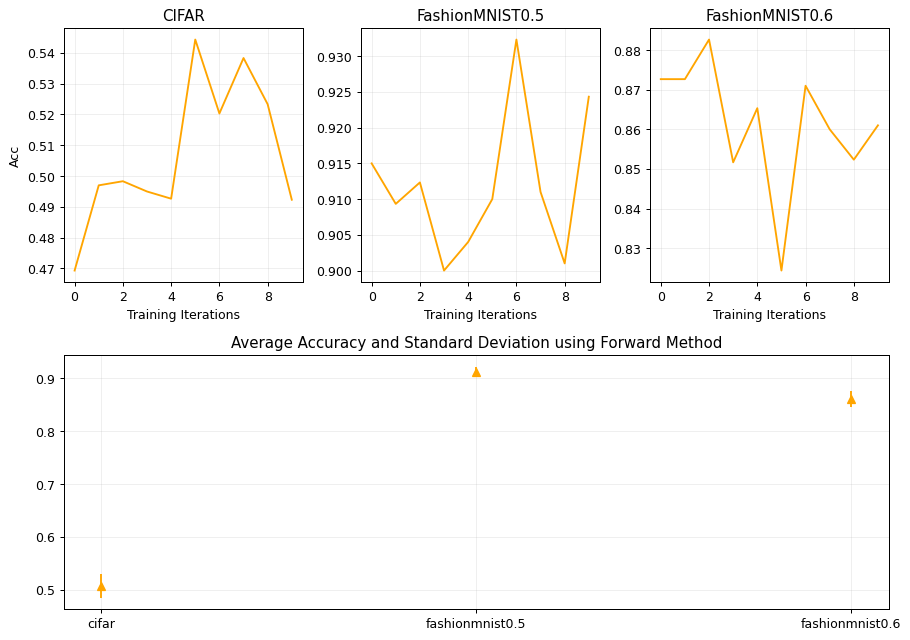

In [ ]:
mean, std = process_results(test_acc_forward_results, title="Forward Method")

### 4.2.- Classifier using T-Revision Method

In this section, we perform the experiments using the T-Revision method implemented before. 

As we did previously, we need to define the architecture of the ResNet model from scratch.

#### ResNet Architecture

In [ ]:
# Convolution Block
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

# Main Block ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_channels=1, num_filter=7, num_classes=3):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(num_channels, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(num_filter)
        self.fc = nn.Linear(64, num_classes)
        self.delta_T = nn.Linear(num_classes, num_classes, False)
        nn.init.zeros_(self.delta_T.weight)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x, revision=False, plot_deltaT=False):
        correction = self.delta_T.weight
        if plot_deltaT:
          print("Corr", correction)
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        if revision:
            return out, correction
        else:
            return out

#### Loss function

In [ ]:
class ReweightingLoss(torch.nn.Module):
    def __init__(self):
      super(ReweightingLoss, self).__init__()
      
    def forward(self, out, T, target, revision=None):
      loss = 0.0
      out_softmax = F.softmax(out, dim=1) 
      # If standard mode (revision false)
      if revision is None:
        g_Y = out_softmax.gather(1, target.view(-1,1))
        Tg = torch.mm(T.t(), out_softmax.t())
        Tg_Y = Tg.t().gather(1, target.view(-1,1))
        # requires_grad=True indicates that we want to compute gradients with
        # respect to these Variables during the backward pass.
        beta = torch.nn.Parameter(g_Y / Tg_Y)
        loss = F.cross_entropy(out, target, reduction='none')
        loss = beta.view(1,-1) * loss
        return torch.mean(loss)

      # If revision mode
      else:
        len_t = len(target)
        delta_T = revision
        for i in range(len_t):
            # Add new dimension
            soft_iter = out_softmax[i].unsqueeze(0)
            # Adding correction deltaT to transition matrix
            T = T + delta_T
            # Matrix product
            out_T_transpose = torch.mm(T.t(), soft_iter.t()).t()
            g_Y = soft_iter[:, target[i]]
            Tg_Y = out_T_transpose[:, target[i]]
            # Update beta
            beta = (g_Y/Tg_Y)
            cross_loss = F.cross_entropy(out[i].unsqueeze(0), target[i].unsqueeze(0))
            # Sum loss
            loss += beta * cross_loss
        return loss / len_t

#### Training Function

In [ ]:
def train_model_forward(model, dataloaders, criterion, optimizer, T_matrix, with_revision=False, num_epochs=25):
  """
  Function to train the model
  
  :param model: Model
  :param dataloaders: DataLoader
  :param criterion: Loss function
  :param optimizer: Optimizer
  :param with_revision: True or False
  :param num_epochs: Number of epochs
  :return model: Trained model
  """

  val_acc_history = []
  best_model_wts = copy.deepcopy(model.state_dict())
  revision_evl = []
  best_acc = 0.0

  for epoch in range(num_epochs):
      print('Epoch {}/{}'.format(epoch, num_epochs - 1))
      print('-' * 10)

      # Each epoch has a training and validation phase
      for phase in ['train', 'val']:
          if phase == 'train':
              model.train()  # Set model to training mode
          else:
              model.eval()   # Set model to evaluate mode

          running_loss = 0.0
          running_corrects = 0

          # Iterate over data.
          for b, (inputs, labels) in enumerate(dataloaders[phase]):
              inputs = inputs.to(device)
              labels = labels.to(device)

              # zero the parameter gradients
              optimizer.zero_grad()

              # forward
              if with_revision==True:
                out, revision = model(inputs, revision=with_revision)
                loss = criterion(out, T_matrix, labels, revision)
                prob = F.softmax(out, dim=1)
                out = torch.matmul((T_matrix+revision).t(), prob.t())
              else:
                out = model(inputs)
                loss = criterion(out, T_matrix, labels)
                prob = F.softmax(out, dim=1)
                out = torch.matmul(T_matrix.t(), prob.t())
                
              out = out.t()

              # track history if only in train
              if with_revision==False:
                with torch.set_grad_enabled(phase == 'train'):
                  
                  _, preds = torch.max(out, 1)
                  
                  # backward + optimize only if in training phase
                  if phase == 'train':
                      loss.backward()
                      optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels.data)

              else:
                _, preds = torch.max(out, 1)

                if phase == 'train':
                  loss.backward()
                  optimizer.step()
                #print(loss.item()*inputs.size(0))

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                if abs(loss.item()* inputs.size(0)) < 0.02:
                  break

          epoch_loss = running_loss / len(dataloaders[phase].dataset)
          epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
          if with_revision==True:
            revision_evl.append(revision)

          print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

          # deep copy the model
          if phase == 'val' and epoch_acc > best_acc:
              best_acc = epoch_acc
              best_model_wts = copy.deepcopy(model.state_dict())
          if phase == 'val':
              val_acc_history.append(epoch_acc)

      print()

  print('Best val Acc: {:4f}'.format(best_acc))

  # load best model weights
  model.load_state_dict(best_model_wts)
  return model, val_acc_history, revision_evl

#### Run Experiment

In [ ]:
available_datasets = {'cifar': '/content/drive/My Drive/comp5328-assignment-2/data/CIFAR.npz',
                      'fashionmnist0.5': '/content/drive/My Drive/comp5328-assignment-2/data/FashionMNIST0.5.npz',
                      'fashionmnist0.6': '/content/drive/My Drive/comp5328-assignment-2/data/FashionMNIST0.6.npz'}

# Training the model n_iters
n_iters = 10

# Set seed
seed_torch()

test_acc_trevision_results = {'cifar': [],
                              'fashionmnist0.5': [],
                              'fashionmnist0.6': []}

test_revision_trevision_results = {'cifar': [],
                                   'fashionmnist0.5': [],
                                   'fashionmnist0.6': []}

# Iterate over each dataset
for d in list(available_datasets.keys()):
  dataset = d

  # Load dataset
  if dataset.lower() in available_datasets:
    dir = available_datasets[dataset.lower()]
    T_matrix = T_matrices[dataset.lower()]
    X_train, y_train, X_test, y_test = load_data(dir)
    print('-'*60)
    print('-'*60)
    print(f"\nDataset {dataset} loaded.\n")

    print(f"Shape Xtr: {X_train.shape}")
    print(f"Shape Str: {y_train.shape}")
    print(f"Shape Xts: {X_test.shape}")
    print(f"Shape Yts: {y_test.shape}")

    print(f"\nTransition Matrix: \n{T_matrix}")
    print('.'*30)
  else:
    print("Dataset not valid. The dataset available are: cifar, fashionmnist0.5 and fashionmnist0.6")

  # Detect if GPU or CPU
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
      
  # Define parameters
  if dataset.lower() == 'cifar':
    n_channels = 3
    n_filters = 8
  else:
    n_channels = 1
    n_filters = 7

  num_classes = 3
  batch_size = 100
  num_epochs = 60
  learning_rate = 0.001
  
  for n in range(n_iters):
    print(f"\nTraining iteration: {n}")

    # Clean cache each iteration
    with torch.no_grad():
        torch.cuda.empty_cache()

    # We did not set a seed for train_test_split thus, it would generate different samples each iteration
    train_loader, val_loader, test_loader = get_loader(X_train=X_train, 
                                                    y_train=y_train, 
                                                    X_test=X_test, 
                                                    y_test=y_test, 
                                                    batch_size=batch_size)

    dataloaders_dict = {'train': train_loader, 'val': val_loader}


    # Initialize model
    model_modified_resnet = ResNet(ResidualBlock, [2, 2, 2], 
                                   num_channels=n_channels, 
                                   num_filter=n_filters, 
                                   num_classes=num_classes).to(device)

    # If GPU: send the model to GPU
    model_modified_resnet = model_modified_resnet.to(device)

    # Define optimizer
    optimizer = optim.Adam(model_modified_resnet.parameters(), lr=learning_rate)

    # Define Loss Function
    criterion = ReweightingLoss()

    # Train model - Revision FALSE
    model_modified_resnet, hist, _ = train_model_forward(model_modified_resnet, 
                                                         dataloaders_dict, 
                                                         criterion, 
                                                         optimizer, 
                                                         T_matrix, 
                                                         with_revision=False, 
                                                         num_epochs=num_epochs)
    
    # Train and Evaluate model - Revision TRUE
    print("Revision TRUE")
    model_modified_resnet, hist, revision_ls = train_model_forward(model_modified_resnet,
                                                                   dataloaders_dict, 
                                                                   criterion, 
                                                                   optimizer, 
                                                                   T_matrix, 
                                                                   with_revision=True, 
                                                                   num_epochs=5)
    
    # Generate predictions on the test set
    y_true, y_pred, acc, outputs = prediction(model_modified_resnet, test_loader, device, revision=True)

    test_acc_trevision_results[dataset].append(acc)
    test_revision_trevision_results[dataset].append(revision_ls)
    print(f"Accuracy on test set using T-Revision Method: {acc}\n")

Streaming output truncated to the last 5000 lines.
train Loss: 0.6540 Acc: 0.4735
val Loss: 0.6655 Acc: 0.4689

Epoch 2/59
----------
train Loss: 0.6451 Acc: 0.4727
val Loss: 0.6481 Acc: 0.4861

Epoch 3/59
----------
train Loss: 0.6460 Acc: 0.4796
val Loss: 0.3987 Acc: 0.4225

Epoch 4/59
----------
train Loss: 0.6475 Acc: 0.4799
val Loss: 0.6406 Acc: 0.4853

Epoch 5/59
----------
train Loss: 0.6316 Acc: 0.4833
val Loss: 0.6961 Acc: 0.4819

Epoch 6/59
----------
train Loss: 0.6390 Acc: 0.4829
val Loss: 0.6267 Acc: 0.4881

Epoch 7/59
----------
train Loss: 0.6233 Acc: 0.4824
val Loss: 0.6330 Acc: 0.4636

Epoch 8/59
----------
train Loss: 0.6150 Acc: 0.4847
val Loss: 0.6269 Acc: 0.4756

Epoch 9/59
----------
train Loss: 0.6161 Acc: 0.4901
val Loss: 0.6072 Acc: 0.4764

Epoch 10/59
----------
train Loss: 0.6051 Acc: 0.4880
val Loss: 0.6407 Acc: 0.4672

Epoch 11/59
----------
train Loss: 0.5914 Acc: 0.4894
val Loss: 0.5984 Acc: 0.4808

Epoch 12/59
----------
train Loss: 0.5870 Acc: 0.4899
va

#### Results

We can print the dictionary `test_acc_forward_results` which has stored the results of the accuracy on the test set.

In [ ]:
# Copy values
test_acc_trevision_results_backup = test_acc_trevision_results 

# Create dataframe from dictionary
df = pd.DataFrame(test_acc_trevision_results)
df

,cifar,fashionmnist0.5,fashionmnist0.6
0,0.626333,0.911000,0.873667
1,0.630333,0.936000,0.881667
2,0.529667,0.915000,0.866000
3,0.600333,0.913667,0.877333
4,0.538333,0.939333,0.886333
5,0.531333,0.933667,0.863000
6,0.457333,0.933333,0.826667
7,0.683000,0.943667,0.867333
8,0.588000,0.928333,0.869000
9,0.486667,0.937333,0.851333


In [ ]:
# Save results
import pickle
with open('test_acc_trevision_results.pkl', 'wb') as fp:
    pickle.dump(test_acc_trevision_results, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('test_acc_trevision_results.pkl', 'rb') as fp:
    test_load = pickle.load(fp)

We will calculate the mean value a standard deviation for each dataset using the function implemented in the last section.

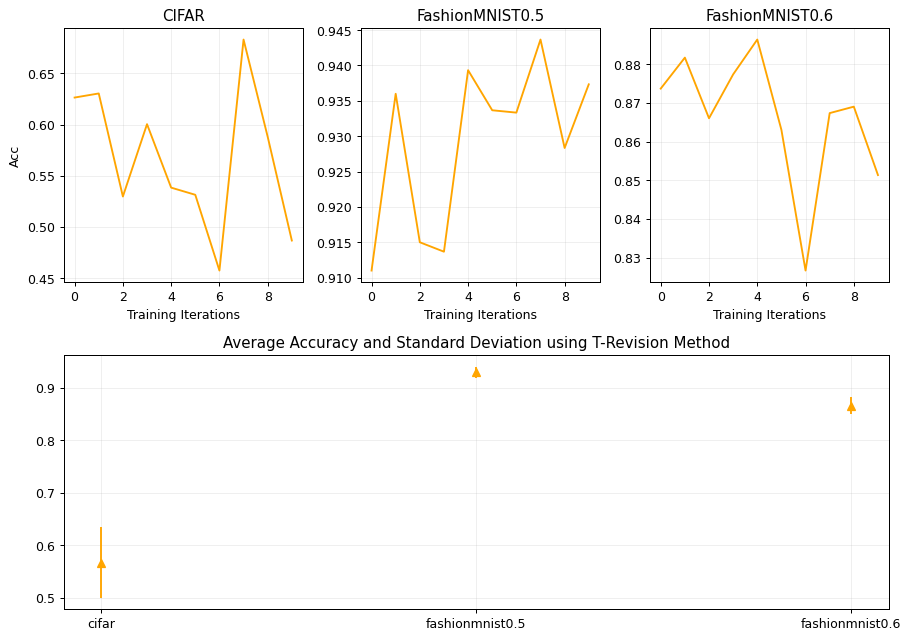

In [ ]:
mean, std = process_results(test_acc_trevision_results, title="T-Revision Method")

We can show the transition matrices modified by the correction layer:

$$T + \Delta T$$

In [ ]:
for d in list(available_datasets.keys()):
  dataset = d
  T_matrix = T_matrices[dataset.lower()]
  corr_aver = sum(x[-1] for x in test_revision_trevision_results[dataset])/len(test_revision_trevision_results[dataset])
  print(f"Dataset: {dataset}")
  print(f"\nT_matrix: \n{T_matrix}")
  print(f"\nCorrection: \n{corr_aver}")
  print(f"\nT+Correction: \n{T_matrix + corr_aver}")
  print('---'*10)
#test_revision_trevision_results['cifar'][-1][-1]

Dataset: cifar

T_matrix: 
tensor([[0.4395, 0.3019, 0.2586],
        [0.2830, 0.4672, 0.2498],
        [0.2788, 0.2901, 0.4311]], device='cuda:0')

Correction: 
tensor([[0.0332, 0.0366, 0.0286],
        [0.0416, 0.0449, 0.0462],
        [0.0322, 0.0508, 0.0372]], device='cuda:0', grad_fn=<DivBackward0>)

T+Correction: 
tensor([[0.4726, 0.3386, 0.2872],
        [0.3246, 0.5122, 0.2960],
        [0.3111, 0.3409, 0.4683]], device='cuda:0', grad_fn=<AddBackward0>)
------------------------------
Dataset: fashionmnist0.5

T_matrix: 
tensor([[0.5000, 0.2000, 0.3000],
        [0.3000, 0.5000, 0.2000],
        [0.2000, 0.3000, 0.5000]], device='cuda:0')

Correction: 
tensor([[0.0279, 0.0216, 0.0400],
        [0.0243, 0.0219, 0.0228],
        [0.0307, 0.0331, 0.0282]], device='cuda:0', grad_fn=<DivBackward0>)

T+Correction: 
tensor([[0.5279, 0.2216, 0.3400],
        [0.3243, 0.5219, 0.2228],
        [0.2307, 0.3331, 0.5282]], device='cuda:0', grad_fn=<AddBackward0>)
-----------------------------

### 4.3.- Classifier using Importance Reweighting Method

In this section, we perform the experiments using the Importance Reweighting method. We use the functions we implemented previously for T-Revision but we won't perform the `Revision=True` step.

As we did previously, we need to define the architecture of the ResNet model from scratch.

#### ResNet Function

In [ ]:
# Convolution Block
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

# Main Block ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_channels=1, num_filter=7, num_classes=3):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(num_channels, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(num_filter)
        self.fc = nn.Linear(64, num_classes)
        self.delta_T = nn.Linear(num_classes, num_classes, False)
        nn.init.zeros_(self.delta_T.weight)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x, revision=False, plot_deltaT=False):
        correction = self.delta_T.weight
        if plot_deltaT:
          print("Corr", correction)
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        if revision:
            return out, correction
        else:
            return out

#### Loss Function

In [ ]:
class ReweightingLoss(torch.nn.Module):
    def __init__(self):
      super(ReweightingLoss, self).__init__()
      
    def forward(self, out, T, target):
      loss = 0.0
      out_softmax = F.softmax(out, dim=1) 
      # If standard mode (revision false)
      g_Y = out_softmax.gather(1, target.view(-1,1))
      Tg = torch.mm(T.t(), out_softmax.t())
      Tg_Y = Tg.t().gather(1, target.view(-1,1))
      # requires_grad=True indicates that we want to compute gradients with
      # respect to these Variables during the backward pass.
      beta = torch.nn.Parameter(g_Y / Tg_Y)
      loss = F.cross_entropy(out, target, reduction='none')
      loss = beta.view(1,-1) * loss
      return torch.mean(loss)

#### Training Function

In [ ]:
def train_model_forward(model, dataloaders, criterion, optimizer, T_matrix, with_revision=False, num_epochs=25):
  """
  Function to train the model
  
  :param model: Model
  :param dataloaders: DataLoader
  :param criterion: Loss function
  :param optimizer: Optimizer
  :param with_revision: True or False
  :param num_epochs: Number of epochs
  :return model: Trained model
  """

  val_acc_history = []
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(num_epochs):
      print('Epoch {}/{}'.format(epoch, num_epochs - 1))
      print('-' * 10)

      # Each epoch has a training and validation phase
      for phase in ['train', 'val']:
          if phase == 'train':
              model.train()  # Set model to training mode
          else:
              model.eval()   # Set model to evaluate mode

          running_loss = 0.0
          running_corrects = 0

          # Iterate over data.
          for b, (inputs, labels) in enumerate(dataloaders[phase]):
              inputs = inputs.to(device)
              labels = labels.to(device)

              # zero the parameter gradients
              optimizer.zero_grad()

              # forward
              if with_revision==True:
                out, revision = model(inputs, revision=with_revision)
                loss = criterion(out, T_matrix, labels, revision)
                prob = F.softmax(out, dim=1)
                out = torch.matmul((T_matrix+revision).t(), prob.t())
              else:
                out = model(inputs)
                loss = criterion(out, T_matrix, labels)
                prob = F.softmax(out, dim=1)
                out = torch.matmul(T_matrix.t(), prob.t())
                
              out = out.t()

              # track history if only in train
              if with_revision==False:
                with torch.set_grad_enabled(phase == 'train'):
                  
                  _, preds = torch.max(out, 1)
                  
                  # backward + optimize only if in training phase
                  if phase == 'train':
                      loss.backward()
                      optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels.data)

              else:
                _, preds = torch.max(out, 1)

                if phase == 'train':
                  loss.backward()
                  optimizer.step()
                #print(loss.item()*inputs.size(0))

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                if abs(loss.item()* inputs.size(0)) < 0.02:
                  break

          epoch_loss = running_loss / len(dataloaders[phase].dataset)
          epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

          print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

          # deep copy the model
          if phase == 'val' and epoch_acc > best_acc:
              best_acc = epoch_acc
              best_model_wts = copy.deepcopy(model.state_dict())
          if phase == 'val':
              val_acc_history.append(epoch_acc)

      print()

  print('Best val Acc: {:4f}'.format(best_acc))

  # load best model weights
  model.load_state_dict(best_model_wts)
  return model, val_acc_history

#### Run Experiment

In [ ]:
available_datasets = {'cifar': '/content/drive/My Drive/comp5328-assignment-2/data/CIFAR.npz',
                      'fashionmnist0.5': '/content/drive/My Drive/comp5328-assignment-2/data/FashionMNIST0.5.npz',
                      'fashionmnist0.6': '/content/drive/My Drive/comp5328-assignment-2/data/FashionMNIST0.6.npz'}

# Training the model n_iters
n_iters = 10

# Set seed
seed_torch()

test_acc_impreweighting_results = {'cifar': [],
                                   'fashionmnist0.5': [],
                                   'fashionmnist0.6': []}

# Iterate over each dataset
for d in list(available_datasets.keys()):
  dataset = d

  # Load dataset
  if dataset.lower() in available_datasets:
    dir = available_datasets[dataset.lower()]
    T_matrix = T_matrices[dataset.lower()]
    X_train, y_train, X_test, y_test = load_data(dir)
    print('-'*60)
    print('-'*60)
    print(f"\nDataset {dataset} loaded.\n")

    print(f"Shape Xtr: {X_train.shape}")
    print(f"Shape Str: {y_train.shape}")
    print(f"Shape Xts: {X_test.shape}")
    print(f"Shape Yts: {y_test.shape}")

    print(f"\nTransition Matrix: \n{T_matrix}")
    print('.'*30)
  else:
    print("Dataset not valid. The dataset available are: cifar, fashionmnist0.5 and fashionmnist0.6")

  # Detect if GPU or CPU
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
      
  # Define parameters
  if dataset.lower() == 'cifar':
    n_channels = 3
    n_filters = 8
  else:
    n_channels = 1
    n_filters = 7

  num_classes = 3
  batch_size = 100
  num_epochs = 60
  learning_rate = 0.001
  
  for n in range(n_iters):
    print(f"\nTraining iteration: {n}")

    # Clean cache each iteration
    with torch.no_grad():
        torch.cuda.empty_cache()

    # We did not set a seed for train_test_split thus, it would generate different samples each iteration
    train_loader, val_loader, test_loader = get_loader(X_train=X_train, 
                                                    y_train=y_train, 
                                                    X_test=X_test, 
                                                    y_test=y_test, 
                                                    batch_size=batch_size)

    dataloaders_dict = {'train': train_loader, 'val': val_loader}


    # Initialize model
    model_modified_resnet = ResNet(ResidualBlock, [2, 2, 2], 
                                   num_channels=n_channels, 
                                   num_filter=n_filters, 
                                   num_classes=num_classes).to(device)

    # If GPU: send the model to GPU
    model_modified_resnet = model_modified_resnet.to(device)

    # Define optimizer
    optimizer = optim.Adam(model_modified_resnet.parameters(), lr=learning_rate)

    # Define Loss Function
    criterion = ReweightingLoss()

    # Train model - Revision FALSE
    model_modified_resnet, hist = train_model_forward(model_modified_resnet, 
                                                      dataloaders_dict, 
                                                      criterion, 
                                                      optimizer, 
                                                      T_matrix, 
                                                      with_revision=False, 
                                                      num_epochs=num_epochs)

    # Generate predictions on the test set
    y_true, y_pred, acc, outputs = prediction(model_modified_resnet, test_loader, device)

    test_acc_impreweighting_results[dataset].append(acc)
    print(f"Accuracy on test set using Importance Reweighting Method: {acc}\n")

Streaming output truncated to the last 5000 lines.
val Loss: 0.1879 Acc: 0.4306

Epoch 35/59
----------
train Loss: 0.1386 Acc: 0.6880
val Loss: 0.2034 Acc: 0.4142

Epoch 36/59
----------
train Loss: 0.1316 Acc: 0.6922
val Loss: 0.1747 Acc: 0.4247

Epoch 37/59
----------
train Loss: 0.1242 Acc: 0.6978
val Loss: 0.1778 Acc: 0.4142

Epoch 38/59
----------
train Loss: 0.1160 Acc: 0.7067
val Loss: 0.1664 Acc: 0.4333

Epoch 39/59
----------
train Loss: 0.1122 Acc: 0.7074
val Loss: 0.1728 Acc: 0.4111

Epoch 40/59
----------
train Loss: 0.1051 Acc: 0.7144
val Loss: 0.1728 Acc: 0.4172

Epoch 41/59
----------
train Loss: 0.1049 Acc: 0.7201
val Loss: 0.1643 Acc: 0.4058

Epoch 42/59
----------
train Loss: 0.0971 Acc: 0.7258
val Loss: 0.1558 Acc: 0.4275

Epoch 43/59
----------
train Loss: 0.0935 Acc: 0.7301
val Loss: 0.1491 Acc: 0.4244

Epoch 44/59
----------
train Loss: 0.0932 Acc: 0.7318
val Loss: 0.1370 Acc: 0.4203

Epoch 45/59
----------
train Loss: 0.0866 Acc: 0.7410
val Loss: 0.1431 Acc: 0.4

#### Results

As we did previously, we can print the dictionary `test_acc_impreweighting_results` which has stored the results of the accuracy on the test set.

In [ ]:
# Copy values
test_acc_impreweighting_results_backup = test_acc_impreweighting_results 

# Create dataframe from dictionary
df = pd.DataFrame(test_acc_impreweighting_results)
df

In [ ]:
# Save results
import pickle
with open('test_acc_impreweighting_results.pkl', 'wb') as fp:
    pickle.dump(test_acc_impreweighting_results, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
import pickle
with open('test_acc_impreweighting_results.pkl', 'rb') as fp:
    test_load = pickle.load(fp)

In [ ]:
mean, std = process_results(test_acc_impreweighting_results, title="Importance Reweighting Method")

### 4.4.- Baseline Results

In this section, we train the ResNet model without any noisy label method and we will generate graphs to compare this baseline result with the results obtained in the previous section.

#### Generate Baseline Results

In [ ]:
available_datasets = {'cifar': '/content/drive/My Drive/comp5328-assignment-2/data/CIFAR.npz',
                      'fashionmnist0.5': '/content/drive/My Drive/comp5328-assignment-2/data/FashionMNIST0.5.npz',
                      'fashionmnist0.6': '/content/drive/My Drive/comp5328-assignment-2/data/FashionMNIST0.6.npz'}

# Training the model n_iters
n_iters = 10

# Set seed
seed_torch()

test_acc_baseline_results = {'cifar': [],
                             'fashionmnist0.5': [],
                             'fashionmnist0.6': []}
# Iterate over each dataset
for d in list(available_datasets.keys()):
  dataset = d

  # Load dataset
  if dataset.lower() in available_datasets:
    dir = available_datasets[dataset.lower()]
    # In this case we do not want to use the transition matrix
    # because we want to get a baseline results
    T_matrix = None
    X_train, y_train, X_test, y_test = load_data(dir)
    print('-'*60)
    print('-'*60)
    print(f"\nDataset {dataset} loaded.\n")

    print(f"Shape Xtr: {X_train.shape}")
    print(f"Shape Str: {y_train.shape}")
    print(f"Shape Xts: {X_test.shape}")
    print(f"Shape Yts: {y_test.shape}")

    print(f"\nTransition Matrix: \n{T_matrix}")
    print('.'*30)
  else:
    print("Dataset not valid. The dataset available are: cifar, fashionmnist0.5 and fashionmnist0.6")

  # Detect if GPU or CPU
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
      
  # Define parameters
  if dataset.lower() == 'cifar':
    n_channels = 3
    n_filters = 8
  else:
    n_channels = 1
    n_filters = 7

  num_classes = 3
  batch_size = 100
  num_epochs = 20
  learning_rate = 0.001

  for n in range(n_iters):
    print(f"\nTraining iteration: {n}")

    # Clean cache each iteration
    with torch.no_grad():
        torch.cuda.empty_cache()

    # We did not set a seed for train_test_split thus, it would generate different samples each iteration
    train_loader, val_loader, test_loader = get_loader(X_train=X_train, 
                                                    y_train=y_train, 
                                                    X_test=X_test, 
                                                    y_test=y_test, 
                                                    batch_size=batch_size)

    dataloaders_dict = {'train': train_loader, 'val': val_loader}


    # Initialize model
    model_modified_resnet = ResNet(ResidualBlock, [2, 2, 2], 
                                    num_channels=n_channels, 
                                    num_filter=n_filters, 
                                    num_classes=num_classes).to(device)

    # If GPU: send the model to GPU
    model_modified_resnet = model_modified_resnet.to(device)

    # Define optimizer
    optimizer = optim.Adam(model_modified_resnet.parameters(), lr=learning_rate)

    # Define Loss Function
    criterion = nn.CrossEntropyLoss()

    # Train model
    model_modified_resnet, hist = train_model(model_modified_resnet, 
                                              dataloaders_dict, 
                                              criterion, 
                                              optimizer, 
                                              num_epochs=num_epochs, 
                                              T=None)
    
    # Generate predictions on the test set
    y_true, y_pred, acc, outputs = prediction(model_modified_resnet, test_loader, device)

    test_acc_baseline_results[dataset].append(acc)
    print(f"Accuracy on test set - Baseline: {acc}\n")

------------------------------------------------------------
------------------------------------------------------------

Dataset cifar loaded.

Shape Xtr: (15000, 3, 32, 32)
Shape Str: (15000,)
Shape Xts: (3000, 3, 32, 32)
Shape Yts: (3000,)

Transition Matrix: 
None
..............................

Training iteration: 0
Validation Split: 0.2
Transition Matrix: 
None

Epoch 0/19
----------
train Loss: 1.1058 Acc: 0.3559
val Loss: 1.1005 Acc: 0.3823

Epoch 1/19
----------
train Loss: 1.0927 Acc: 0.3801
val Loss: 1.0991 Acc: 0.3507

Epoch 2/19
----------
train Loss: 1.0892 Acc: 0.3840
val Loss: 1.1067 Acc: 0.3760

Epoch 3/19
----------
train Loss: 1.0885 Acc: 0.3829
val Loss: 1.0973 Acc: 0.3603

Epoch 4/19
----------
train Loss: 1.0854 Acc: 0.3930
val Loss: 1.0965 Acc: 0.3750

Epoch 5/19
----------
train Loss: 1.0800 Acc: 0.4037
val Loss: 1.1007 Acc: 0.3763

Epoch 6/19
----------
train Loss: 1.0749 Acc: 0.4172
val Loss: 1.0978 Acc: 0.3673

Epoch 7/19
----------
train Loss: 1.0664 Acc: 0

In [ ]:
# Copy values
test_acc_baseline_results_backup = test_acc_baseline_results 

# Create dataframe from dictionary
df = pd.DataFrame(test_acc_baseline_results)
df

,cifar,fashionmnist0.5,fashionmnist0.6
0,0.522667,0.924333,0.754667
1,0.593667,0.917667,0.863667
2,0.583000,0.925667,0.821333
3,0.512333,0.898333,0.846667
4,0.497667,0.930000,0.829333
5,0.585333,0.905667,0.782000
6,0.541333,0.922333,0.897333
7,0.509667,0.923000,0.763000
8,0.644000,0.903000,0.841000
9,0.677333,0.932000,0.836000


In [ ]:
# Save results
import pickle
with open('test_acc_baseline_results.pkl', 'wb') as fp:
    pickle.dump(test_acc_baseline_results, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('test_acc_baseline_results.pkl', 'rb') as fp:
    test_load = pickle.load(fp)

#### Combining Results

**Cifar10**

In [ ]:
cifar_baseline = test_acc_baseline_results['cifar']
cifar_forward = test_acc_forward_results['cifar']
cifar_trevision = test_acc_trevision_results['cifar']
cifar_impreweighting = test_acc_impreweighting_results['cifar']

In [ ]:
# Calculate mean and std
cifar_mean = [np.mean(cifar_baseline), np.mean(cifar_forward), np.mean(cifar_impreweighting), np.mean(cifar_trevision)]
cifar_std = [np.std(cifar_baseline),np.std(cifar_forward), np.std(cifar_impreweighting), np.std(cifar_trevision)]

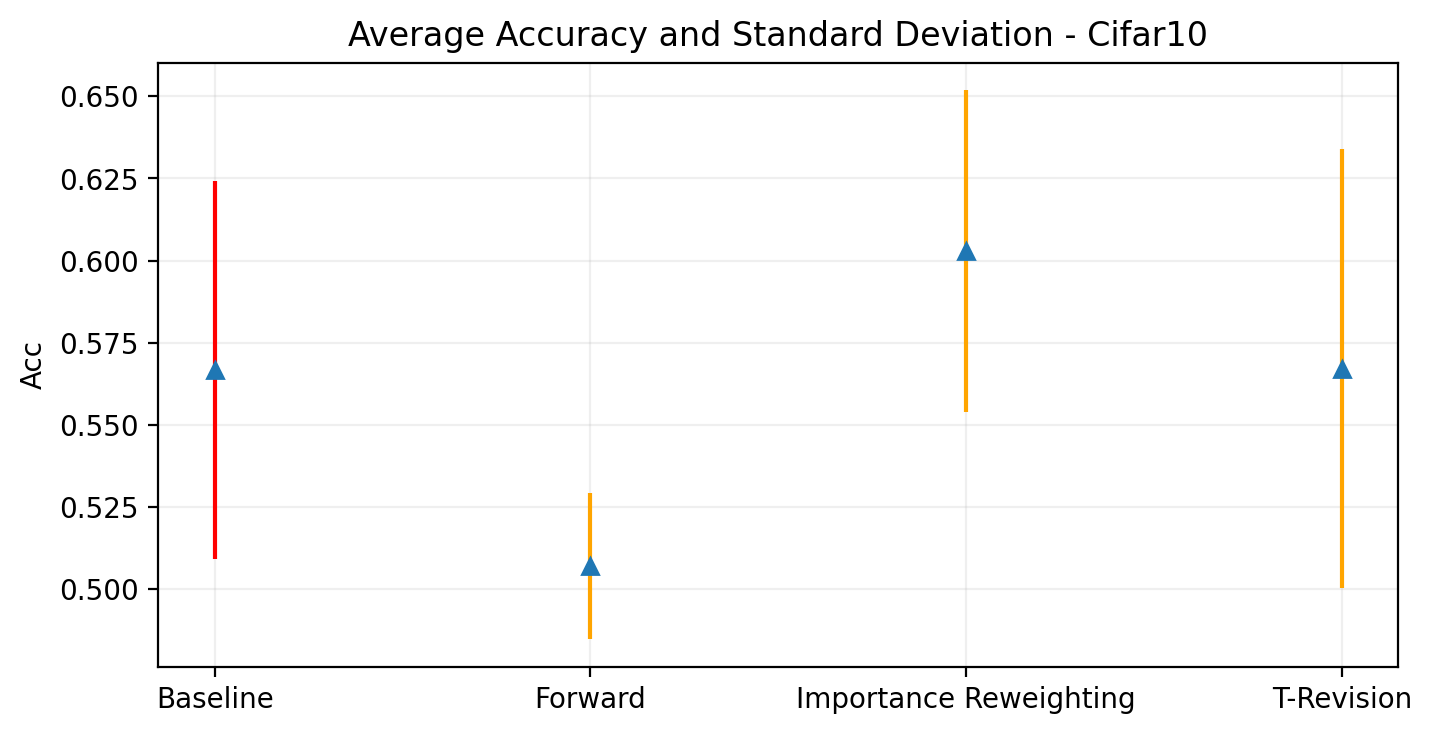

In [ ]:
plt.figure(figsize=(8, 4), dpi=200)
plt.title('Average Accuracy and Standard Deviation - Cifar10')
plt.ylabel("Acc")
plt.errorbar(['Baseline', 'Forward', 'Importance Reweighting', 'T-Revision'], 
             cifar_mean, 
             cifar_std, 
             ecolor=["red", "orange", "orange", "orange"], 
             linestyle='None', 
             marker='^')
plt.grid(alpha=0.2) 

**FashionMNIST0.5**

In [ ]:
# Get values
fashion05_baseline = test_acc_baseline_results['fashionmnist0.5']
fashion05_forward = test_acc_forward_results['fashionmnist0.5']
fashion05_trevision = test_acc_trevision_results['fashionmnist0.5']
fashion05_impreweighting = test_acc_impreweighting_results['fashionmnist0.5']

In [ ]:
# Calculate mean and std
fashion05_mean = [np.mean(fashion05_baseline), np.mean(fashion05_forward), np.mean(fashion05_impreweighting), np.mean(fashion05_trevision)]
fashion05_std = [np.std(fashion05_baseline),np.std(fashion05_forward), np.std(fashion05_impreweighting), np.std(fashion05_trevision)]

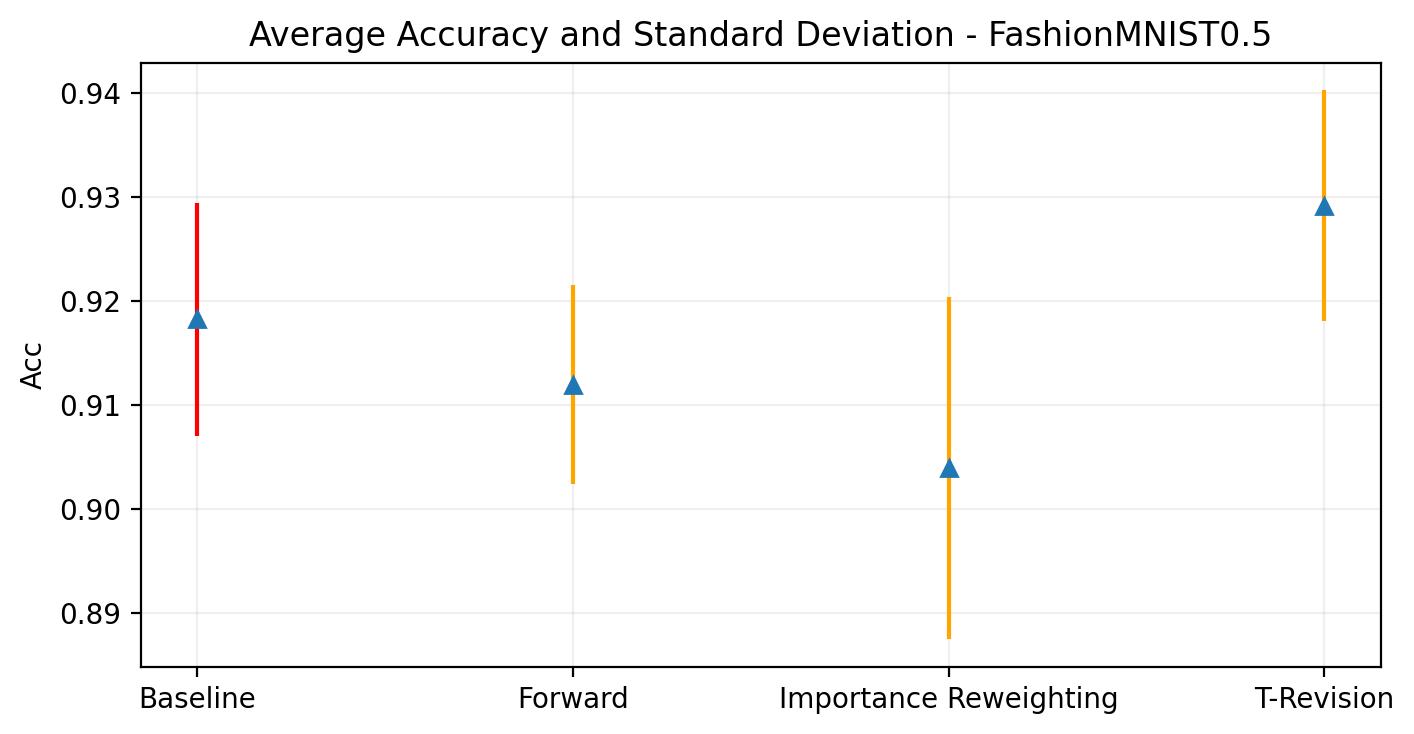

In [ ]:
plt.figure(figsize=(8, 4), dpi=200)
plt.title('Average Accuracy and Standard Deviation - FashionMNIST0.5')
plt.ylabel("Acc")
plt.errorbar(['Baseline', 'Forward', 'Importance Reweighting', 'T-Revision'], 
             fashion05_mean, 
             fashion05_std, 
             ecolor=["red", "orange", "orange", "orange"], 
             linestyle='None', 
             marker='^')
plt.grid(alpha=0.2) 

**FashionMNIST0.6**

In [ ]:
# Get values
fashion06_baseline = test_acc_baseline_results['fashionmnist0.6']
fashion06_forward = test_acc_forward_results['fashionmnist0.6']
fashion06_trevision = test_acc_trevision_results['fashionmnist0.6']
fashion06_impreweighting = test_acc_impreweighting_results['fashionmnist0.6']

In [ ]:
# Calculate mean and std
fashion06_mean = [np.mean(fashion06_baseline), np.mean(fashion06_forward), np.mean(fashion06_impreweighting), np.mean(fashion06_trevision)]
fashion06_std = [np.std(fashion06_baseline),np.std(fashion06_forward), np.std(fashion06_impreweighting), np.std(fashion06_trevision)]

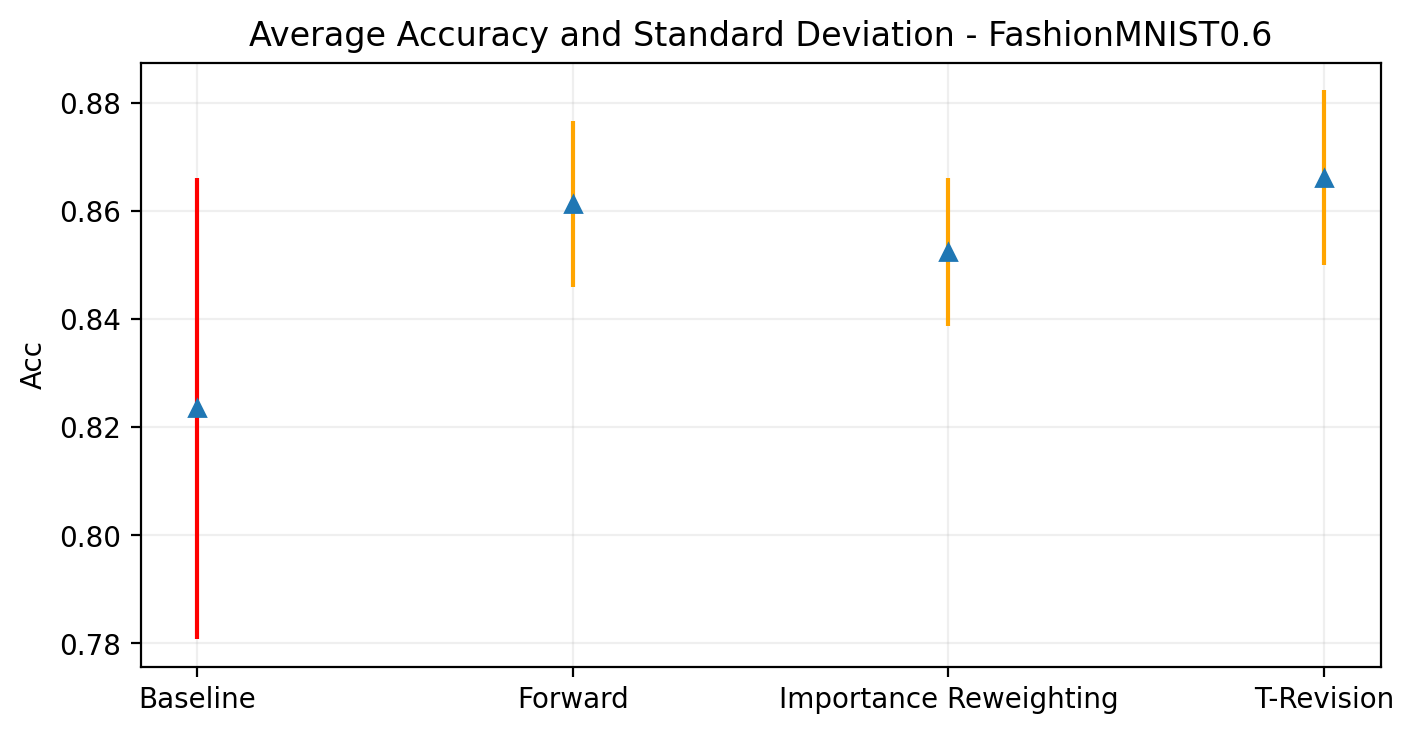

In [ ]:
plt.figure(figsize=(8, 4), dpi=200)
plt.title('Average Accuracy and Standard Deviation - FashionMNIST0.6')
plt.ylabel("Acc")
plt.errorbar(['Baseline', 'Forward', 'Importance Reweighting', 'T-Revision'], 
             fashion06_mean, 
             fashion06_std, 
             ecolor=["red", "orange", "orange", "orange"], 
             linestyle='None', 
             marker='^')
plt.grid(alpha=0.2) 

## 5.- Appendix

This section contains code used to generate graphs for the report.

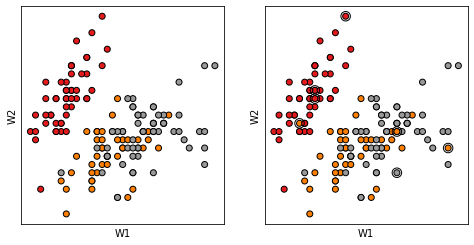

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.decomposition import PCA
import numpy as np

iris = datasets.load_iris()
X = iris.data[:, :2]
y = iris.target

flip = np.random.choice([True, False], len(y), p=[0.05, 0.95])
y_flip = np.random.choice([0,1,2], len(y), p=[0.4, 0.3, 0.3])
z = np.copy(y)
z[flip] = y_flip[flip]

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

plt.figure(2, figsize=(8, 4))
plt.clf()

# Plot the true points

plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1,
            edgecolor='k')
plt.xlabel('W1')
plt.ylabel('W2')
plt.xticks(())
plt.yticks(())

# Plot the noisy points
plt.subplot(1, 2, 2)
plt.scatter(X[:, 0], X[:, 1], c=z, cmap=plt.cm.Set1,edgecolor='k')
plt.scatter(X[flip, 0], X[flip, 1], s=90, facecolors='none', edgecolors='black')
plt.xlabel('W1') 
plt.ylabel('W2')
plt.xticks(())
plt.yticks(())

plt.show()